Correlation Matrix:
                sediment_thick       gwt    predom      vs30       dem  \
sediment_thick        1.000000 -0.216763  0.842865 -0.714979 -0.612316   
gwt                  -0.216763  1.000000 -0.253263  0.247926  0.106787   
predom                0.842865 -0.253263  1.000000 -0.740071 -0.632388   
vs30                 -0.714979  0.247926 -0.740071  1.000000  0.572196   
dem                  -0.612316  0.106787 -0.632388  0.572196  1.000000   
pga                   0.324652  0.247579  0.301166 -0.395725 -0.393711   
geo_form              0.279673 -0.152896  0.388118 -0.227223 -0.265748   
near_dis             -0.376476  0.024184 -0.446482  0.357406  0.317857   
near_dis_norm        -0.377148  0.024713 -0.447509  0.358859  0.318728   
near_dist            -0.422079  0.013253 -0.515818  0.432735  0.414401   
LIQ                   0.736590 -0.247550  0.807827 -0.638401 -0.564791   

                     pga  geo_form  near_dis  near_dis_norm  near_dist  \
sediment_thick  0

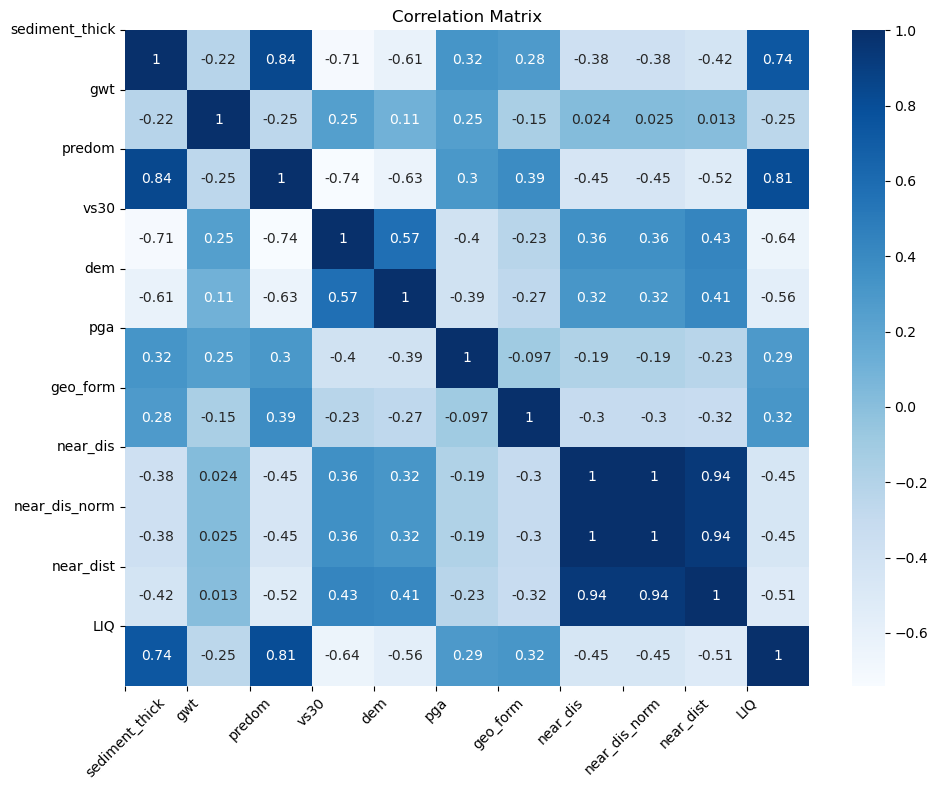

Variance Inflation Factor (VIF):
        VIF        features
0  2.692961        near_dis
1  8.584742  sediment_thick
2  9.325158          predom
3  8.550982            vs30
4  5.150100             pga
5  6.126440        geo_form
Epoch 1, Loss: 0.797
Epoch 2, Loss: 0.733
Epoch 3, Loss: 0.672
Epoch 4, Loss: 0.622
Epoch 5, Loss: 0.569
Epoch 6, Loss: 0.527
Epoch 7, Loss: 0.486
Epoch 8, Loss: 0.449
Epoch 9, Loss: 0.422
Epoch 10, Loss: 0.392
Epoch 11, Loss: 0.376
Epoch 12, Loss: 0.364
Epoch 13, Loss: 0.344
Epoch 14, Loss: 0.332
Epoch 15, Loss: 0.322
Epoch 16, Loss: 0.319
Epoch 17, Loss: 0.314
Epoch 18, Loss: 0.305
Epoch 19, Loss: 0.299
Epoch 20, Loss: 0.299
Epoch 21, Loss: 0.289
Epoch 22, Loss: 0.288
Epoch 23, Loss: 0.291
Epoch 24, Loss: 0.288
Epoch 25, Loss: 0.279
Epoch 26, Loss: 0.282
Epoch 27, Loss: 0.282
Epoch 28, Loss: 0.276
Epoch 29, Loss: 0.274
Epoch 30, Loss: 0.275
Epoch 31, Loss: 0.271
Epoch 32, Loss: 0.272
Epoch 33, Loss: 0.270
Epoch 34, Loss: 0.271
Epoch 35, Loss: 0.262
Epoch 36, 

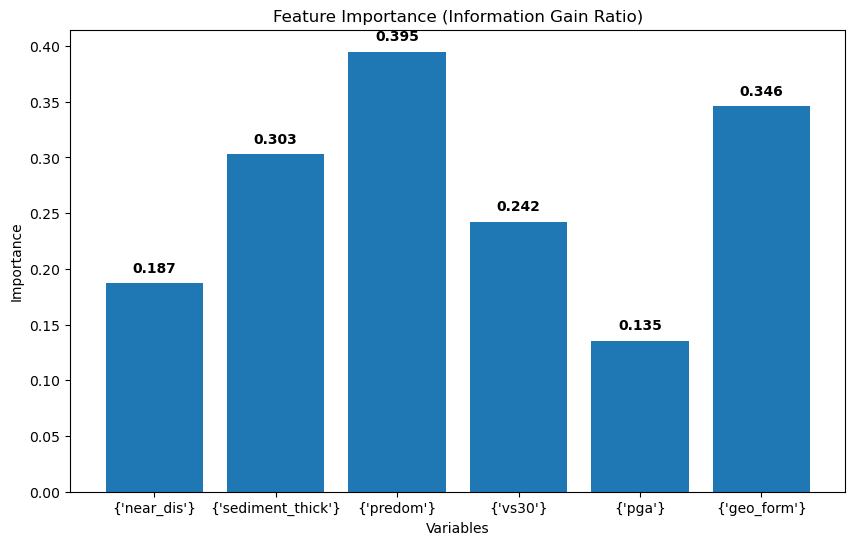

Test Accuracy: 0.909
Precision: 0.846
Recall: 0.873
F1-score: 0.859
AUROC: 0.957
Cohen Kappa Score: 0.792
Confusion Matrix:
tensor([[125.,  10.],
        [  8.,  55.]])


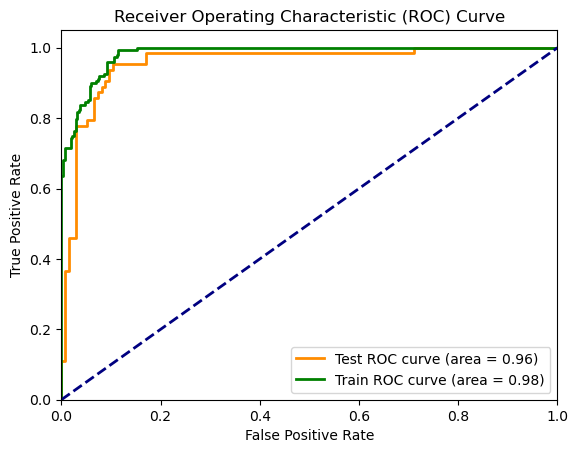

True Positive Rate: 0.873
False Positive Rate: 0.074
True Negative Rate: 0.926
False Negative Rate: 0.127


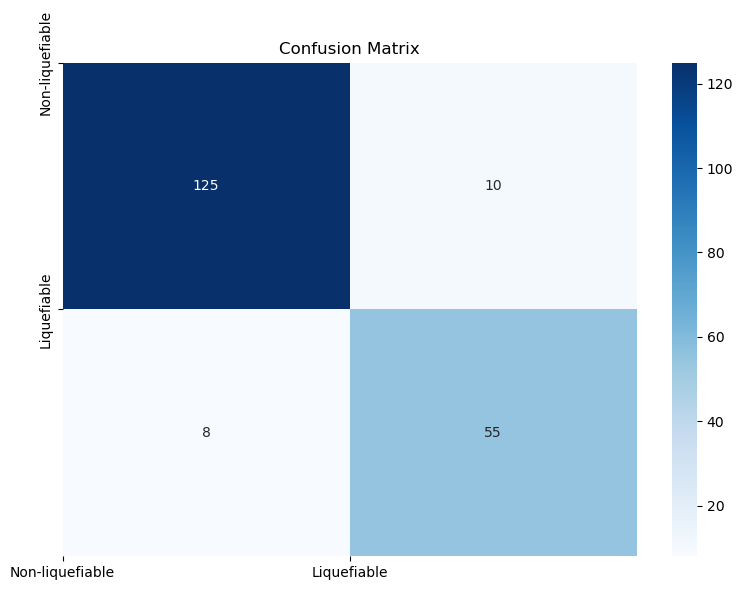

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

# Set a random seed for reproducibility
torch.manual_seed(36)
np.random.seed(36)

# Load the dataset
data = pd.read_csv("C:\\Users\\LE\\Downloads\\THESIS\\Program\\CSV\\GRID_LABEL_KTMBASIN_classify_v2.2.csv")

# Calculate correlation of the dataset
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Draw heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
#plt.imshow(correlation_matrix, interpolation='nearest')
plt.title("Correlation Matrix")
#plt.colorbar()
tick_marks = [i for i in range(len(data.columns))]
plt.xticks(tick_marks, data.columns, rotation=45)
plt.yticks(tick_marks, data.columns)
plt.tight_layout()
plt.show()

# Preprocess the data
X = data[["near_dis", "sediment_thick", "predom", "vs30", "pga", "geo_form"]]
y = data["LIQ"]

# Calculate VIF
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print("Variance Inflation Factor (VIF):")
print(vif)

# Create a custom dataset class
class LiquefactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx, :].values
        y = self.y.iloc[idx]
        return {
            'x': torch.tensor(x, dtype=torch.float),
            'y': torch.tensor(y, dtype=torch.long)
        }

# Create data loaders

max_depth = 10  # maximum depth of the decision tree
n_estimators = 100  # number of decision trees in the ensemble
random_state = 36  # random state for reproducibility
test_size = 0.3 # test size for testing data

# Hyperparameters
hidden_size = 64
learning_rate = 0.0004
num_layers = 3
epochs = 300
batch_size = 80

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) 
 
dataset_train = LiquefactionDataset(X_train, y_train) 
dataset_test = LiquefactionDataset(X_test, y_test)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)

# Define the DNN model
class DNNModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(6, hidden_size)  # input layer (5) -> hidden layer (128)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)  # hidden layer (128) -> hidden layer (64)
        self.fc3 = nn.Linear(hidden_size//2, 2)  # hidden layer (64) -> output layer (2)
       

    def forward(self, x):
        batch_size = x.size(0)  # get the batch size
        x = x.view(batch_size, 6)  # reshape the input tensor
        x = torch.relu(self.fc1(x))  # activation function for hidden layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = DNNModel(hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, labels = batch['x'], batch['y']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / i:.3f}')

# Calculate feature importance using Information Gain Ratio
information_gain_ratio = mutual_info_classif(X_train, y_train)
print("Feature Importance (Information Gain Ratio):")
for i, importance in enumerate(information_gain_ratio):
    print(f"Feature {i+1}: {X.columns[i]} (importance: {importance:.3f})")

# Draw bar chart for feature importance using Information Gain Ratio
plt.figure(figsize=(10, 6))
plt.bar(range(len(information_gain_ratio)), information_gain_ratio, align="center")
plt.xticks(range(len(information_gain_ratio)), [{X.columns[i]} for i in range(len(information_gain_ratio))])
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.title("Feature Importance (Information Gain Ratio)")
for i,v in enumerate(information_gain_ratio):
    plt.text(i,v+0.01,f"{v:.3f}", ha="center", weight="bold")
plt.show()  
    
# Evaluate the model
model.eval()
test_loss = 0
correct = 0
y_pred_probs = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['x'], batch['y']
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_pred_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = correct / len(test_loader.dataset)
print(f'Test Accuracy: {accuracy:.3f}')

# Calculate precision, recall, F1-score
y_pred = np.array(y_pred_probs) >= 0.5
y_true = np.array(y_true)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

# Calculate AUROC
auroc = roc_auc_score(y_true, y_pred_probs)
print(f'AUROC: {auroc:.3f}')

# Calculate Kappa score
kappa = cohen_kappa_score(y_true, y_pred)
print(f'Cohen Kappa Score: {kappa:.3f}')

# Calculate confusion matrix
conf_mat = torch.zeros(2, 2)
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['x'], batch['y']
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels, predicted):
            conf_mat[t, p] += 1

print("Confusion Matrix:")
print(conf_mat)

# Calculate AUROC for test data
y_pred_probs_test = np.array(y_pred_probs)
y_true_test = np.array(y_true)
auroc_test = roc_auc_score(y_true_test, y_pred_probs_test)
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_probs_test)

# Calculate AUROC for train data
y_pred_probs_train = []
y_true_train = []
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = batch['x'], batch['y']
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred_probs_train.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        y_true_train.extend(labels.cpu().numpy())

y_pred_probs_train = np.array(y_pred_probs_train)
y_true_train = np.array(y_true_train)
auroc_train = roc_auc_score(y_true_train, y_pred_probs_train)
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_pred_probs_train)

# Plot ROC curve for both test and train data
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = %0.2f)' % auroc_test)
plt.plot(fpr_train, tpr_train, color='green', lw=2, label='Train ROC curve (area = %0.2f)' % auroc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Calculate true positive rate, false positive rate, true negative rate, false negative rate
tn, fp, fn, tp = conf_mat.ravel()
tpr = tp / (tp + fn)  # True positive rate
fpr = fp / (fp + tn)  # False positive rate
tnr= tn / (tn + fp)  # True negative rate
fnr = fn / (fn + tp)  # False negative rate

print(f"True Positive Rate: {tpr:.3f}")
print(f"False Positive Rate: {fpr:.3f}")
print(f"True Negative Rate: {tnr:.3f}")
print(f"False Negative Rate: {fnr:.3f}")

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt = '.0f')
#plt.imshow(conf_mat, interpolation='nearest')
plt.title("Confusion Matrix")
#plt.colorbar()
tick_marks = [i for i in range(2)]
plt.xticks(tick_marks, ["Non-liquefiable", "Liquefiable"], rotation=0)
plt.yticks(tick_marks, ["Non-liquefiable", "Liquefiable"])
plt.tight_layout()
plt.show()

In [5]:
mean_score = accuracy_score(y_true, y_pred)
print("Mean Score:", mean_score)

Mean Score: 0.9090909090909091


In [6]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(mse)
print(rmse)

0.09090909090909091
0.30151134457776363


In [6]:
import numpy as np

# Calculate standard deviation of each input parameter
std_near_dis = np.std(X_train['near_dis'])
std_sediment_thick = np.std(X_train['sediment_thick'])
std_vs30 = np.std(X_train['vs30'])
std_predom = np.std(X_train['predom'])
std_pga = np.std(X_train['pga'])
std_geo_form = np.std(X_train['geo_form'])

# Calculate tolerance as 10% of standard deviation
tol_near_dis = std_near_dis * 0.1
tol_sediment_thick = std_sediment_thick * 0.1
tol_vs30 = std_vs30 * 0.1
tol_predom = std_predom * 0.1
tol_pga = std_pga * 0.1
tol_geo_form = std_geo_form * 0.1

print("Tolerance of input parameters:")
print(f"near_dis: {tol_near_dis:.3f}")
print(f"sediment_thick: {tol_sediment_thick:.3f}")
print(f"vs30: {tol_vs30:.3f}")
print(f"predom: {tol_predom:.3f}")
print(f"pga: {tol_pga:.3f}")
print(f"geomap: {tol_geo_form:.3f}")

NameError: name 'X_train' is not defined

In [71]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import Affine
import torch

# Read the shapefile
gdf = gpd.read_file(r'D:\\ARC GIS\\KTM VALLEY\\WGS_1984_UTM_ZONE_45N\\GRID\\GRID_LABEL_KTMBASIN_Classify_v2.2.shp')

# Repeat the predictions to match the number of features
pred_SA_repeated = np.repeat(y_pred_probs_test, len(gdf) // len(y_pred_probs_test) + 1)[:len(gdf)]

# Assign the repeated predictions to a new column in the GeoDataFrame
gdf['LSM'] = pred_SA_repeated

# Set the CRS
gdf.set_crs(epsg=32645, inplace=True)

# Save the GeoDataFrame to a new shapefile
gdf.to_file(r'D:\\ARC GIS\\KTM VALLEY\\WGS_1984_UTM_ZONE_45N\\METHOD 2\\Classify_v2.2\\method2_grid_1_0.3_36_DNN_CLassify_v2.2.shp')

# Get the overall bounds of the GeoDataFrame
minx, miny, maxx, maxy = gdf.total_bounds

# Create a raster output file
with rasterio.open(
    r'D:\\ARC GIS\\KTM VALLEY\\WGS_1984_UTM_ZONE_45N\\METHOD 2\\Classify_v2.2\\method2_grid_1_0.3_36_DNN_CLassify_v2.2.tif',
    'w',
    driver='GTiff',
    height=gdf.shape[0],
    width=gdf.shape[1],
    count=1,
    dtype=rasterio.uint8,
    crs=gdf.crs,
    transform=Affine(30, 0, minx, 0, -30, maxy)
) as dst:
    # Write the LSM values to the raster
    dst.write(gdf['LSM'].values.reshape((1, -1)), 1)

In [10]:
gdf.crs

<Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
import pandas as pd

# Create a DataFrame with X_test, y_test, and y_pred_test
df = pd.DataFrame(X_test, columns=X.columns)
df['LIQ'] = y_test
df['Predicted_LIQ'] = y_pred

# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df)

# Export the DataFrame to an Excel file
#df.to_excel('output_DNN.xlsx', index=False)

     near_dis  bedrockdep  predom  vs30  pga  geo_form  LIQ  Predicted_LIQ
100      1.03           6       9     2    5         7    1           True
170      1.17           7       9     2    4        13    1           True
315      6.78           1       2     2    8         4    0          False
445      1.10           1       1     3    1         9    0          False
428      3.91           3       1     3    2         8    0          False
254      0.05           3       8     2    4        11    1           True
490      2.59           1       1     3    1         9    0          False
60       2.59           1       1     3    5         6    0          False
524      2.55           1       1     3    1         9    0          False
135      0.03           7       9     2    5        11    1           True
348      1.31           1       1     3    5         3    0          False
334      7.45           1       1     3    4         2    0          False
495      1.99           1

Correlation Matrix:
                  Id  EASTING_X  NORTHING_Y  NEAR_DIST  bedrockdep       gwt  \
Id          1.000000   0.992609    0.992609   0.184710   -0.014659 -0.503268   
EASTING_X   0.992609   1.000000    1.000000   0.201224    0.036075 -0.526195   
NORTHING_Y  0.992609   1.000000    1.000000   0.201224    0.036075 -0.526195   
NEAR_DIST   0.184710   0.201224    0.201224   1.000000   -0.374233  0.046478   
bedrockdep -0.014659   0.036075    0.036075  -0.374233    1.000000 -0.216763   
gwt        -0.503268  -0.526195   -0.526195   0.046478   -0.216763  1.000000   
predom      0.077754   0.118491    0.118491  -0.434952    0.842865 -0.253263   
vs30       -0.040734  -0.086495   -0.086495   0.348986   -0.714979  0.247926   
dem_ktm     0.020399  -0.021518   -0.021518   0.289869   -0.612316  0.106787   
pga        -0.672943  -0.619569   -0.619569  -0.163342    0.324652  0.247579   
geomap      0.207581   0.204588    0.204588  -0.310323    0.279673 -0.152896   
LIQ         0.055129

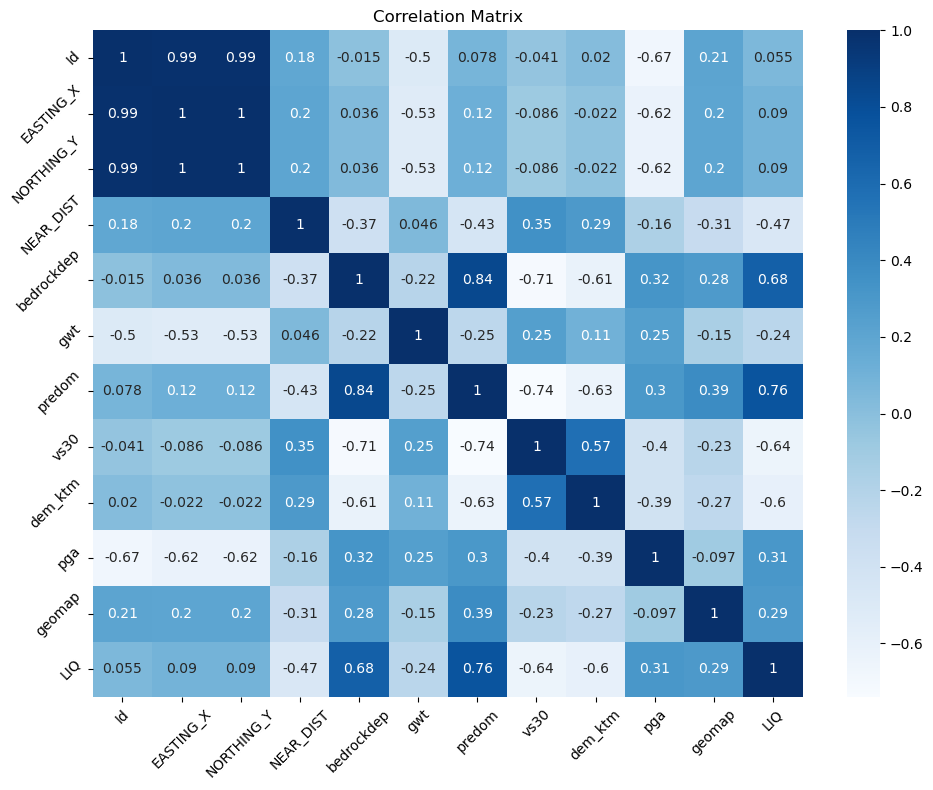

[I 2024-08-07 00:04:48,729] A new study created in memory with name: no-name-6299df31-1d5e-4db5-add3-5c4ebf0cbb4a


Variance Inflation Factor (VIF):
        VIF    features
0  2.562781   NEAR_DIST
1  8.565858  bedrockdep
2  8.368899        vs30
3  9.289309      predom
4  5.154271         pga
5  6.147300      geomap


C:\Users\LE\AppData\Local\Temp\ipykernel_2112\3026926444.py:104: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


Epoch 1, Loss: 0.502
Epoch 2, Loss: 0.369
Epoch 3, Loss: 0.405
Epoch 4, Loss: 0.368
Epoch 5, Loss: 0.356
Epoch 6, Loss: 0.342
Epoch 7, Loss: 0.342
Epoch 8, Loss: 0.310
Epoch 9, Loss: 0.377
Epoch 10, Loss: 0.400
Epoch 11, Loss: 0.333
Epoch 12, Loss: 0.337
Epoch 13, Loss: 0.370
Epoch 14, Loss: 0.306
Epoch 15, Loss: 0.301
Epoch 16, Loss: 0.296
Epoch 17, Loss: 0.283
Epoch 18, Loss: 0.293
Epoch 19, Loss: 0.308
Epoch 20, Loss: 0.357
Epoch 21, Loss: 0.288
Epoch 22, Loss: 0.307
Epoch 23, Loss: 0.313
Epoch 24, Loss: 0.307
Epoch 25, Loss: 0.301
Epoch 26, Loss: 0.313
Epoch 27, Loss: 0.298
Epoch 28, Loss: 0.289
Epoch 29, Loss: 0.302
Epoch 30, Loss: 0.298
Epoch 31, Loss: 0.304
Epoch 32, Loss: 0.286
Epoch 33, Loss: 0.290
Epoch 34, Loss: 0.279
Epoch 35, Loss: 0.312
Epoch 36, Loss: 0.301
Epoch 37, Loss: 0.268
Epoch 38, Loss: 0.300
Epoch 39, Loss: 0.307
Epoch 40, Loss: 0.320
Epoch 41, Loss: 0.279
Epoch 42, Loss: 0.292
Epoch 43, Loss: 0.312
Epoch 44, Loss: 0.278
Epoch 45, Loss: 0.281
Epoch 46, Loss: 0.2

[I 2024-08-07 00:19:09,945] Trial 0 finished with value: -0.8787878787878788 and parameters: {'batch_size': 8, 'learning_rate': 0.0036252514204630146, 'hidden_size': 256, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.671
Epoch 2, Loss: 0.512
Epoch 3, Loss: 0.391
Epoch 4, Loss: 0.335
Epoch 5, Loss: 0.317
Epoch 6, Loss: 0.310
Epoch 7, Loss: 0.304
Epoch 8, Loss: 0.301
Epoch 9, Loss: 0.300
Epoch 10, Loss: 0.297
Epoch 11, Loss: 0.290
Epoch 12, Loss: 0.293
Epoch 13, Loss: 0.292
Epoch 14, Loss: 0.289
Epoch 15, Loss: 0.288
Epoch 16, Loss: 0.288
Epoch 17, Loss: 0.286
Epoch 18, Loss: 0.285
Epoch 19, Loss: 0.282
Epoch 20, Loss: 0.281
Epoch 21, Loss: 0.281
Epoch 22, Loss: 0.278
Epoch 23, Loss: 0.281
Epoch 24, Loss: 0.279
Epoch 25, Loss: 0.277
Epoch 26, Loss: 0.275
Epoch 27, Loss: 0.278
Epoch 28, Loss: 0.276
Epoch 29, Loss: 0.273
Epoch 30, Loss: 0.275
Epoch 31, Loss: 0.274
Epoch 32, Loss: 0.274
Epoch 33, Loss: 0.272
Epoch 34, Loss: 0.272
Epoch 35, Loss: 0.273
Epoch 36, Loss: 0.271
Epoch 37, Loss: 0.272
Epoch 38, Loss: 0.270
Epoch 39, Loss: 0.270
Epoch 40, Loss: 0.268
Epoch 41, Loss: 0.270
Epoch 42, Loss: 0.268
Epoch 43, Loss: 0.267
Epoch 44, Loss: 0.267
Epoch 45, Loss: 0.267
Epoch 46, Loss: 0.2

[I 2024-08-07 00:22:39,294] Trial 1 finished with value: -0.8686868686868687 and parameters: {'batch_size': 4, 'learning_rate': 5.730351638511804e-05, 'hidden_size': 64, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.507
Epoch 2, Loss: 0.362
Epoch 3, Loss: 0.327
Epoch 4, Loss: 0.319
Epoch 5, Loss: 0.312
Epoch 6, Loss: 0.308
Epoch 7, Loss: 0.303
Epoch 8, Loss: 0.296
Epoch 9, Loss: 0.296
Epoch 10, Loss: 0.295
Epoch 11, Loss: 0.293
Epoch 12, Loss: 0.294
Epoch 13, Loss: 0.289
Epoch 14, Loss: 0.286
Epoch 15, Loss: 0.289
Epoch 16, Loss: 0.285
Epoch 17, Loss: 0.284
Epoch 18, Loss: 0.282
Epoch 19, Loss: 0.282
Epoch 20, Loss: 0.283
Epoch 21, Loss: 0.281
Epoch 22, Loss: 0.283
Epoch 23, Loss: 0.278
Epoch 24, Loss: 0.281
Epoch 25, Loss: 0.278
Epoch 26, Loss: 0.271
Epoch 27, Loss: 0.278
Epoch 28, Loss: 0.273
Epoch 29, Loss: 0.277
Epoch 30, Loss: 0.271
Epoch 31, Loss: 0.274
Epoch 32, Loss: 0.276
Epoch 33, Loss: 0.271
Epoch 34, Loss: 0.272
Epoch 35, Loss: 0.270
Epoch 36, Loss: 0.270
Epoch 37, Loss: 0.272
Epoch 38, Loss: 0.266
Epoch 39, Loss: 0.269
Epoch 40, Loss: 0.266
Epoch 41, Loss: 0.269
Epoch 42, Loss: 0.268
Epoch 43, Loss: 0.266
Epoch 44, Loss: 0.266
Epoch 45, Loss: 0.263
Epoch 46, Loss: 0.2

[I 2024-08-07 00:25:18,742] Trial 2 finished with value: -0.8686868686868687 and parameters: {'batch_size': 8, 'learning_rate': 7.647839559863638e-05, 'hidden_size': 256, 'num_layers': 1}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.454
Epoch 2, Loss: 0.349
Epoch 3, Loss: 0.371
Epoch 4, Loss: 0.393
Epoch 5, Loss: 0.343
Epoch 6, Loss: 0.340
Epoch 7, Loss: 0.321
Epoch 8, Loss: 0.344
Epoch 9, Loss: 0.352
Epoch 10, Loss: 0.329
Epoch 11, Loss: 0.306
Epoch 12, Loss: 0.318
Epoch 13, Loss: 0.340
Epoch 14, Loss: 0.330
Epoch 15, Loss: 0.327
Epoch 16, Loss: 0.330
Epoch 17, Loss: 0.312
Epoch 18, Loss: 0.324
Epoch 19, Loss: 0.325
Epoch 20, Loss: 0.347
Epoch 21, Loss: 0.336
Epoch 22, Loss: 0.311
Epoch 23, Loss: 0.327
Epoch 24, Loss: 0.343
Epoch 25, Loss: 0.329
Epoch 26, Loss: 0.316
Epoch 27, Loss: 0.328
Epoch 28, Loss: 0.330
Epoch 29, Loss: 0.329
Epoch 30, Loss: 0.329
Epoch 31, Loss: 0.338
Epoch 32, Loss: 0.318
Epoch 33, Loss: 0.329
Epoch 34, Loss: 0.334
Epoch 35, Loss: 0.367
Epoch 36, Loss: 0.363
Epoch 37, Loss: 0.337
Epoch 38, Loss: 0.327
Epoch 39, Loss: 0.314
Epoch 40, Loss: 0.312
Epoch 41, Loss: 0.321
Epoch 42, Loss: 0.329
Epoch 43, Loss: 0.304
Epoch 44, Loss: 0.328
Epoch 45, Loss: 0.314
Epoch 46, Loss: 0.3

[I 2024-08-07 00:27:47,636] Trial 3 finished with value: -0.8737373737373737 and parameters: {'batch_size': 8, 'learning_rate': 0.021247889010730367, 'hidden_size': 64, 'num_layers': 1}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 13.609
Epoch 2, Loss: 0.695
Epoch 3, Loss: 0.697
Epoch 4, Loss: 0.691
Epoch 5, Loss: 0.689
Epoch 6, Loss: 0.678
Epoch 7, Loss: 0.687
Epoch 8, Loss: 0.688
Epoch 9, Loss: 0.694
Epoch 10, Loss: 0.691
Epoch 11, Loss: 0.694
Epoch 12, Loss: 0.687
Epoch 13, Loss: 0.683
Epoch 14, Loss: 0.697
Epoch 15, Loss: 0.691
Epoch 16, Loss: 0.683
Epoch 17, Loss: 0.695
Epoch 18, Loss: 0.686
Epoch 19, Loss: 0.683
Epoch 20, Loss: 0.680
Epoch 21, Loss: 0.695
Epoch 22, Loss: 0.697
Epoch 23, Loss: 0.695
Epoch 24, Loss: 0.700
Epoch 25, Loss: 0.687
Epoch 26, Loss: 0.683
Epoch 27, Loss: 0.679
Epoch 28, Loss: 0.689
Epoch 29, Loss: 0.674
Epoch 30, Loss: 0.695
Epoch 31, Loss: 0.685
Epoch 32, Loss: 0.688
Epoch 33, Loss: 0.693
Epoch 34, Loss: 0.690
Epoch 35, Loss: 0.684
Epoch 36, Loss: 0.687
Epoch 37, Loss: 0.689
Epoch 38, Loss: 0.673
Epoch 39, Loss: 0.685
Epoch 40, Loss: 0.698
Epoch 41, Loss: 0.682
Epoch 42, Loss: 0.701
Epoch 43, Loss: 0.688
Epoch 44, Loss: 0.689
Epoch 45, Loss: 0.690
Epoch 46, Loss: 0.

[I 2024-08-07 00:36:32,077] Trial 4 finished with value: -0.6313131313131313 and parameters: {'batch_size': 16, 'learning_rate': 0.09589891657811232, 'hidden_size': 256, 'num_layers': 2}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.512
Epoch 2, Loss: 0.369
Epoch 3, Loss: 0.336
Epoch 4, Loss: 0.328
Epoch 5, Loss: 0.307
Epoch 6, Loss: 0.302
Epoch 7, Loss: 0.295
Epoch 8, Loss: 0.293
Epoch 9, Loss: 0.288
Epoch 10, Loss: 0.282
Epoch 11, Loss: 0.287
Epoch 12, Loss: 0.284
Epoch 13, Loss: 0.280
Epoch 14, Loss: 0.279
Epoch 15, Loss: 0.282
Epoch 16, Loss: 0.284
Epoch 17, Loss: 0.277
Epoch 18, Loss: 0.276
Epoch 19, Loss: 0.278
Epoch 20, Loss: 0.274
Epoch 21, Loss: 0.272
Epoch 22, Loss: 0.273
Epoch 23, Loss: 0.274
Epoch 24, Loss: 0.271
Epoch 25, Loss: 0.273
Epoch 26, Loss: 0.268
Epoch 27, Loss: 0.270
Epoch 28, Loss: 0.272
Epoch 29, Loss: 0.270
Epoch 30, Loss: 0.265
Epoch 31, Loss: 0.266
Epoch 32, Loss: 0.268
Epoch 33, Loss: 0.262
Epoch 34, Loss: 0.263
Epoch 35, Loss: 0.263
Epoch 36, Loss: 0.260
Epoch 37, Loss: 0.258
Epoch 38, Loss: 0.259
Epoch 39, Loss: 0.261
Epoch 40, Loss: 0.259
Epoch 41, Loss: 0.254
Epoch 42, Loss: 0.247
Epoch 43, Loss: 0.259
Epoch 44, Loss: 0.259
Epoch 45, Loss: 0.256
Epoch 46, Loss: 0.2

[I 2024-08-07 00:39:52,171] Trial 5 finished with value: -0.8737373737373737 and parameters: {'batch_size': 4, 'learning_rate': 0.00021308746347013094, 'hidden_size': 64, 'num_layers': 2}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.480
Epoch 2, Loss: 0.362
Epoch 3, Loss: 0.346
Epoch 4, Loss: 0.368
Epoch 5, Loss: 0.336
Epoch 6, Loss: 0.307
Epoch 7, Loss: 0.356
Epoch 8, Loss: 0.314
Epoch 9, Loss: 0.300
Epoch 10, Loss: 0.307
Epoch 11, Loss: 0.306
Epoch 12, Loss: 0.322
Epoch 13, Loss: 0.316
Epoch 14, Loss: 0.297
Epoch 15, Loss: 0.302
Epoch 16, Loss: 0.318
Epoch 17, Loss: 0.322
Epoch 18, Loss: 0.293
Epoch 19, Loss: 0.287
Epoch 20, Loss: 0.303
Epoch 21, Loss: 0.277
Epoch 22, Loss: 0.292
Epoch 23, Loss: 0.297
Epoch 24, Loss: 0.290
Epoch 25, Loss: 0.299
Epoch 26, Loss: 0.296
Epoch 27, Loss: 0.292
Epoch 28, Loss: 0.301
Epoch 29, Loss: 0.292
Epoch 30, Loss: 0.305
Epoch 31, Loss: 0.280
Epoch 32, Loss: 0.276
Epoch 33, Loss: 0.293
Epoch 34, Loss: 0.274
Epoch 35, Loss: 0.278
Epoch 36, Loss: 0.281
Epoch 37, Loss: 0.280
Epoch 38, Loss: 0.281
Epoch 39, Loss: 0.282
Epoch 40, Loss: 0.275
Epoch 41, Loss: 0.269
Epoch 42, Loss: 0.283
Epoch 43, Loss: 0.290
Epoch 44, Loss: 0.272
Epoch 45, Loss: 0.268
Epoch 46, Loss: 0.2

[I 2024-08-07 00:45:02,646] Trial 6 finished with value: -0.8686868686868687 and parameters: {'batch_size': 2, 'learning_rate': 0.005260532740859181, 'hidden_size': 128, 'num_layers': 2}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.871
Epoch 2, Loss: 0.641
Epoch 3, Loss: 0.555
Epoch 4, Loss: 0.496
Epoch 5, Loss: 0.455
Epoch 6, Loss: 0.425
Epoch 7, Loss: 0.403
Epoch 8, Loss: 0.387
Epoch 9, Loss: 0.373
Epoch 10, Loss: 0.363
Epoch 11, Loss: 0.353
Epoch 12, Loss: 0.348
Epoch 13, Loss: 0.341
Epoch 14, Loss: 0.336
Epoch 15, Loss: 0.331
Epoch 16, Loss: 0.327
Epoch 17, Loss: 0.324
Epoch 18, Loss: 0.321
Epoch 19, Loss: 0.317
Epoch 20, Loss: 0.314
Epoch 21, Loss: 0.312
Epoch 22, Loss: 0.310
Epoch 23, Loss: 0.308
Epoch 24, Loss: 0.306
Epoch 25, Loss: 0.305
Epoch 26, Loss: 0.302
Epoch 27, Loss: 0.302
Epoch 28, Loss: 0.301
Epoch 29, Loss: 0.298
Epoch 30, Loss: 0.298
Epoch 31, Loss: 0.296
Epoch 32, Loss: 0.296
Epoch 33, Loss: 0.294
Epoch 34, Loss: 0.293
Epoch 35, Loss: 0.293
Epoch 36, Loss: 0.291
Epoch 37, Loss: 0.290
Epoch 38, Loss: 0.291
Epoch 39, Loss: 0.290
Epoch 40, Loss: 0.289
Epoch 41, Loss: 0.288
Epoch 42, Loss: 0.287
Epoch 43, Loss: 0.287
Epoch 44, Loss: 0.286
Epoch 45, Loss: 0.285
Epoch 46, Loss: 0.2

[I 2024-08-07 00:47:55,069] Trial 7 finished with value: -0.8737373737373737 and parameters: {'batch_size': 2, 'learning_rate': 1.9948457021356153e-05, 'hidden_size': 256, 'num_layers': 1}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.561
Epoch 2, Loss: 0.417
Epoch 3, Loss: 0.366
Epoch 4, Loss: 0.340
Epoch 5, Loss: 0.326
Epoch 6, Loss: 0.321
Epoch 7, Loss: 0.310
Epoch 8, Loss: 0.309
Epoch 9, Loss: 0.306
Epoch 10, Loss: 0.302
Epoch 11, Loss: 0.301
Epoch 12, Loss: 0.298
Epoch 13, Loss: 0.297
Epoch 14, Loss: 0.296
Epoch 15, Loss: 0.294
Epoch 16, Loss: 0.293
Epoch 17, Loss: 0.292
Epoch 18, Loss: 0.292
Epoch 19, Loss: 0.290
Epoch 20, Loss: 0.287
Epoch 21, Loss: 0.288
Epoch 22, Loss: 0.289
Epoch 23, Loss: 0.283
Epoch 24, Loss: 0.281
Epoch 25, Loss: 0.285
Epoch 26, Loss: 0.282
Epoch 27, Loss: 0.283
Epoch 28, Loss: 0.278
Epoch 29, Loss: 0.282
Epoch 30, Loss: 0.282
Epoch 31, Loss: 0.280
Epoch 32, Loss: 0.278
Epoch 33, Loss: 0.280
Epoch 34, Loss: 0.278
Epoch 35, Loss: 0.277
Epoch 36, Loss: 0.277
Epoch 37, Loss: 0.278
Epoch 38, Loss: 0.275
Epoch 39, Loss: 0.276
Epoch 40, Loss: 0.275
Epoch 41, Loss: 0.275
Epoch 42, Loss: 0.274
Epoch 43, Loss: 0.274
Epoch 44, Loss: 0.273
Epoch 45, Loss: 0.273
Epoch 46, Loss: 0.2

[I 2024-08-07 00:52:13,596] Trial 8 finished with value: -0.8636363636363636 and parameters: {'batch_size': 16, 'learning_rate': 3.850513915381253e-05, 'hidden_size': 128, 'num_layers': 2}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.633
Epoch 2, Loss: 0.531
Epoch 3, Loss: 0.458
Epoch 4, Loss: 0.414
Epoch 5, Loss: 0.390
Epoch 6, Loss: 0.375
Epoch 7, Loss: 0.365
Epoch 8, Loss: 0.358
Epoch 9, Loss: 0.350
Epoch 10, Loss: 0.346
Epoch 11, Loss: 0.340
Epoch 12, Loss: 0.334
Epoch 13, Loss: 0.328
Epoch 14, Loss: 0.328
Epoch 15, Loss: 0.321
Epoch 16, Loss: 0.318
Epoch 17, Loss: 0.315
Epoch 18, Loss: 0.314
Epoch 19, Loss: 0.310
Epoch 20, Loss: 0.309
Epoch 21, Loss: 0.308
Epoch 22, Loss: 0.306
Epoch 23, Loss: 0.304
Epoch 24, Loss: 0.302
Epoch 25, Loss: 0.300
Epoch 26, Loss: 0.300
Epoch 27, Loss: 0.297
Epoch 28, Loss: 0.297
Epoch 29, Loss: 0.297
Epoch 30, Loss: 0.295
Epoch 31, Loss: 0.293
Epoch 32, Loss: 0.293
Epoch 33, Loss: 0.291
Epoch 34, Loss: 0.291
Epoch 35, Loss: 0.290
Epoch 36, Loss: 0.289
Epoch 37, Loss: 0.288
Epoch 38, Loss: 0.288
Epoch 39, Loss: 0.288
Epoch 40, Loss: 0.288
Epoch 41, Loss: 0.285
Epoch 42, Loss: 0.283
Epoch 43, Loss: 0.284
Epoch 44, Loss: 0.281
Epoch 45, Loss: 0.284
Epoch 46, Loss: 0.2

[I 2024-08-07 00:54:49,341] Trial 9 finished with value: -0.8737373737373737 and parameters: {'batch_size': 16, 'learning_rate': 3.709964389072294e-05, 'hidden_size': 64, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.259
Epoch 1, Loss: 0.419
Epoch 2, Loss: 0.362
Epoch 3, Loss: 0.318
Epoch 4, Loss: 0.305
Epoch 5, Loss: 0.310
Epoch 6, Loss: 0.299
Epoch 7, Loss: 0.298
Epoch 8, Loss: 0.309
Epoch 9, Loss: 0.308
Epoch 10, Loss: 0.292
Epoch 11, Loss: 0.289
Epoch 12, Loss: 0.281
Epoch 13, Loss: 0.291
Epoch 14, Loss: 0.288
Epoch 15, Loss: 0.283
Epoch 16, Loss: 0.308
Epoch 17, Loss: 0.275
Epoch 18, Loss: 0.291
Epoch 19, Loss: 0.276
Epoch 20, Loss: 0.293
Epoch 21, Loss: 0.278
Epoch 22, Loss: 0.277
Epoch 23, Loss: 0.268
Epoch 24, Loss: 0.262
Epoch 25, Loss: 0.263
Epoch 26, Loss: 0.267
Epoch 27, Loss: 0.269
Epoch 28, Loss: 0.249
Epoch 29, Loss: 0.250
Epoch 30, Loss: 0.260
Epoch 31, Loss: 0.261
Epoch 32, Loss: 0.257
Epoch 33, Loss: 0.254
Epoch 34, Loss: 0.241
Epoch 35, Loss: 0.241
Epoch 36, Loss: 0.232
Epoch 37, Loss: 0.229
Epoch 38, Loss: 0.246
Epoch 39, Loss: 0.231
Epoch 40, Loss: 0.222
Epoch 41, Loss: 0.218
Epoch 42, Loss: 0.234
Epoch 43, Loss: 0.233
Epoch 44, Loss: 0.234
Epoch 45, Loss: 0.

[I 2024-08-07 00:59:08,262] Trial 10 finished with value: -0.8535353535353535 and parameters: {'batch_size': 1, 'learning_rate': 0.0009694591968817986, 'hidden_size': 256, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.219
Epoch 1, Loss: 0.483
Epoch 2, Loss: 0.343
Epoch 3, Loss: 0.364
Epoch 4, Loss: 0.317
Epoch 5, Loss: 0.320
Epoch 6, Loss: 0.307
Epoch 7, Loss: 0.329
Epoch 8, Loss: 0.303
Epoch 9, Loss: 0.312
Epoch 10, Loss: 0.325
Epoch 11, Loss: 0.330
Epoch 12, Loss: 0.322
Epoch 13, Loss: 0.311
Epoch 14, Loss: 0.315
Epoch 15, Loss: 0.322
Epoch 16, Loss: 0.305
Epoch 17, Loss: 0.339
Epoch 18, Loss: 0.300
Epoch 19, Loss: 0.320
Epoch 20, Loss: 0.310
Epoch 21, Loss: 0.328
Epoch 22, Loss: 0.315
Epoch 23, Loss: 0.310
Epoch 24, Loss: 0.308
Epoch 25, Loss: 0.299
Epoch 26, Loss: 0.308
Epoch 27, Loss: 0.323
Epoch 28, Loss: 0.323
Epoch 29, Loss: 0.303
Epoch 30, Loss: 0.323
Epoch 31, Loss: 0.313
Epoch 32, Loss: 0.306
Epoch 33, Loss: 0.310
Epoch 34, Loss: 0.324
Epoch 35, Loss: 0.313
Epoch 36, Loss: 0.307
Epoch 37, Loss: 0.303
Epoch 38, Loss: 0.317
Epoch 39, Loss: 0.324
Epoch 40, Loss: 0.311
Epoch 41, Loss: 0.297
Epoch 42, Loss: 0.311
Epoch 43, Loss: 0.326
Epoch 44, Loss: 0.341
Epoch 45, Loss: 0.

[I 2024-08-07 01:00:35,485] Trial 11 finished with value: -0.8181818181818182 and parameters: {'batch_size': 8, 'learning_rate': 0.018160301233001684, 'hidden_size': 64, 'num_layers': 1}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.305
Epoch 1, Loss: 0.730
Epoch 2, Loss: 0.505
Epoch 3, Loss: 0.480
Epoch 4, Loss: 0.377
Epoch 5, Loss: 0.445
Epoch 6, Loss: 0.356
Epoch 7, Loss: 0.360
Epoch 8, Loss: 0.319
Epoch 9, Loss: 0.334
Epoch 10, Loss: 0.317
Epoch 11, Loss: 0.326
Epoch 12, Loss: 0.338
Epoch 13, Loss: 0.332
Epoch 14, Loss: 0.305
Epoch 15, Loss: 0.323
Epoch 16, Loss: 0.314
Epoch 17, Loss: 0.326
Epoch 18, Loss: 0.318
Epoch 19, Loss: 0.298
Epoch 20, Loss: 0.308
Epoch 21, Loss: 0.312
Epoch 22, Loss: 0.295
Epoch 23, Loss: 0.315
Epoch 24, Loss: 0.306
Epoch 25, Loss: 0.281
Epoch 26, Loss: 0.292
Epoch 27, Loss: 0.292
Epoch 28, Loss: 0.294
Epoch 29, Loss: 0.305
Epoch 30, Loss: 0.286
Epoch 31, Loss: 0.288
Epoch 32, Loss: 0.296
Epoch 33, Loss: 0.292
Epoch 34, Loss: 0.330
Epoch 35, Loss: 0.291
Epoch 36, Loss: 0.310
Epoch 37, Loss: 0.301
Epoch 38, Loss: 0.298
Epoch 39, Loss: 0.301
Epoch 40, Loss: 0.303
Epoch 41, Loss: 0.281
Epoch 42, Loss: 0.288
Epoch 43, Loss: 0.297
Epoch 44, Loss: 0.279
Epoch 45, Loss: 0.

[I 2024-08-07 01:05:09,279] Trial 12 finished with value: -0.8737373737373737 and parameters: {'batch_size': 8, 'learning_rate': 0.005139399046621545, 'hidden_size': 256, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 1, Loss: 0.573
Epoch 2, Loss: 0.388
Epoch 3, Loss: 0.378
Epoch 4, Loss: 0.332
Epoch 5, Loss: 0.387
Epoch 6, Loss: 0.352
Epoch 7, Loss: 0.401
Epoch 8, Loss: 0.405
Epoch 9, Loss: 0.357
Epoch 10, Loss: 0.365
Epoch 11, Loss: 0.405
Epoch 12, Loss: 0.402
Epoch 13, Loss: 0.393
Epoch 14, Loss: 0.377
Epoch 15, Loss: 0.392
Epoch 16, Loss: 0.356
Epoch 17, Loss: 0.407
Epoch 18, Loss: 0.385
Epoch 19, Loss: 0.388
Epoch 20, Loss: 0.364
Epoch 21, Loss: 0.380
Epoch 22, Loss: 0.392
Epoch 23, Loss: 0.399
Epoch 24, Loss: 0.359
Epoch 25, Loss: 0.354
Epoch 26, Loss: 0.391
Epoch 27, Loss: 0.396
Epoch 28, Loss: 0.375
Epoch 29, Loss: 0.358
Epoch 30, Loss: 0.379
Epoch 31, Loss: 0.355
Epoch 32, Loss: 0.384
Epoch 33, Loss: 0.369
Epoch 34, Loss: 0.378
Epoch 35, Loss: 0.391
Epoch 36, Loss: 0.365
Epoch 37, Loss: 0.401
Epoch 38, Loss: 0.393
Epoch 39, Loss: 0.380
Epoch 40, Loss: 0.335
Epoch 41, Loss: 0.382
Epoch 42, Loss: 0.379
Epoch 43, Loss: 0.357
Epoch 44, Loss: 0.387
Epoch 45, Loss: 0.377
Epoch 46, Loss: 0.3

[I 2024-08-07 01:06:36,897] Trial 13 finished with value: -0.8232323232323232 and parameters: {'batch_size': 8, 'learning_rate': 0.03704422217367786, 'hidden_size': 64, 'num_layers': 1}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.363
Epoch 1, Loss: 0.425
Epoch 2, Loss: 0.360
Epoch 3, Loss: 0.329
Epoch 4, Loss: 0.327
Epoch 5, Loss: 0.289
Epoch 6, Loss: 0.294
Epoch 7, Loss: 0.320
Epoch 8, Loss: 0.315
Epoch 9, Loss: 0.305
Epoch 10, Loss: 0.309
Epoch 11, Loss: 0.283
Epoch 12, Loss: 0.289
Epoch 13, Loss: 0.277
Epoch 14, Loss: 0.287
Epoch 15, Loss: 0.274
Epoch 16, Loss: 0.287
Epoch 17, Loss: 0.286
Epoch 18, Loss: 0.298
Epoch 19, Loss: 0.290
Epoch 20, Loss: 0.275
Epoch 21, Loss: 0.283
Epoch 22, Loss: 0.284
Epoch 23, Loss: 0.277
Epoch 24, Loss: 0.279
Epoch 25, Loss: 0.275
Epoch 26, Loss: 0.259
Epoch 27, Loss: 0.273
Epoch 28, Loss: 0.271
Epoch 29, Loss: 0.282
Epoch 30, Loss: 0.276
Epoch 31, Loss: 0.266
Epoch 32, Loss: 0.271
Epoch 33, Loss: 0.262
Epoch 34, Loss: 0.260
Epoch 35, Loss: 0.262
Epoch 36, Loss: 0.271
Epoch 37, Loss: 0.272
Epoch 38, Loss: 0.262
Epoch 39, Loss: 0.257
Epoch 40, Loss: 0.258
Epoch 41, Loss: 0.260
Epoch 42, Loss: 0.252
Epoch 43, Loss: 0.247
Epoch 44, Loss: 0.254
Epoch 45, Loss: 0.

[I 2024-08-07 01:09:44,867] Trial 14 finished with value: -0.8636363636363636 and parameters: {'batch_size': 8, 'learning_rate': 0.00195758524202659, 'hidden_size': 128, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.224
Epoch 1, Loss: 0.695
Epoch 2, Loss: 0.423
Epoch 3, Loss: 0.333
Epoch 4, Loss: 0.330
Epoch 5, Loss: 0.324
Epoch 6, Loss: 0.325
Epoch 7, Loss: 0.316
Epoch 8, Loss: 0.313
Epoch 9, Loss: 0.300
Epoch 10, Loss: 0.302
Epoch 11, Loss: 0.327
Epoch 12, Loss: 0.303
Epoch 13, Loss: 0.311
Epoch 14, Loss: 0.306
Epoch 15, Loss: 0.319
Epoch 16, Loss: 0.305
Epoch 17, Loss: 0.309
Epoch 18, Loss: 0.294
Epoch 19, Loss: 0.303
Epoch 20, Loss: 0.307
Epoch 21, Loss: 0.303
Epoch 22, Loss: 0.308
Epoch 23, Loss: 0.306
Epoch 24, Loss: 0.302
Epoch 25, Loss: 0.305
Epoch 26, Loss: 0.304
Epoch 27, Loss: 0.301
Epoch 28, Loss: 0.291
Epoch 29, Loss: 0.298
Epoch 30, Loss: 0.299
Epoch 31, Loss: 0.310
Epoch 32, Loss: 0.308
Epoch 33, Loss: 0.298
Epoch 34, Loss: 0.305
Epoch 35, Loss: 0.305
Epoch 36, Loss: 0.303
Epoch 37, Loss: 0.288
Epoch 38, Loss: 0.309
Epoch 39, Loss: 0.303
Epoch 40, Loss: 0.302
Epoch 41, Loss: 0.302
Epoch 42, Loss: 0.310
Epoch 43, Loss: 0.287
Epoch 44, Loss: 0.284
Epoch 45, Loss: 0.

[I 2024-08-07 01:11:33,363] Trial 15 finished with value: -0.8484848484848485 and parameters: {'batch_size': 1, 'learning_rate': 0.012969292764589448, 'hidden_size': 256, 'num_layers': 1}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.291
Epoch 1, Loss: 0.504
Epoch 2, Loss: 0.333
Epoch 3, Loss: 0.312
Epoch 4, Loss: 0.306
Epoch 5, Loss: 0.303
Epoch 6, Loss: 0.293
Epoch 7, Loss: 0.290
Epoch 8, Loss: 0.286
Epoch 9, Loss: 0.287
Epoch 10, Loss: 0.284
Epoch 11, Loss: 0.291
Epoch 12, Loss: 0.277
Epoch 13, Loss: 0.286
Epoch 14, Loss: 0.283
Epoch 15, Loss: 0.278
Epoch 16, Loss: 0.279
Epoch 17, Loss: 0.279
Epoch 18, Loss: 0.278
Epoch 19, Loss: 0.274
Epoch 20, Loss: 0.271
Epoch 21, Loss: 0.273
Epoch 22, Loss: 0.272
Epoch 23, Loss: 0.275
Epoch 24, Loss: 0.267
Epoch 25, Loss: 0.270
Epoch 26, Loss: 0.271
Epoch 27, Loss: 0.269
Epoch 28, Loss: 0.268
Epoch 29, Loss: 0.266
Epoch 30, Loss: 0.263
Epoch 31, Loss: 0.267
Epoch 32, Loss: 0.266
Epoch 33, Loss: 0.267
Epoch 34, Loss: 0.252
Epoch 35, Loss: 0.265
Epoch 36, Loss: 0.263
Epoch 37, Loss: 0.262
Epoch 38, Loss: 0.260
Epoch 39, Loss: 0.263
Epoch 40, Loss: 0.265
Epoch 41, Loss: 0.260
Epoch 42, Loss: 0.258
Epoch 43, Loss: 0.257
Epoch 44, Loss: 0.255
Epoch 45, Loss: 0.

[I 2024-08-07 01:12:59,375] Trial 16 finished with value: -0.8636363636363636 and parameters: {'batch_size': 8, 'learning_rate': 0.0005944622258843146, 'hidden_size': 64, 'num_layers': 1}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.224
Epoch 1, Loss: 0.435
Epoch 2, Loss: 0.352
Epoch 3, Loss: 0.355
Epoch 4, Loss: 0.366
Epoch 5, Loss: 0.321
Epoch 6, Loss: 0.319
Epoch 7, Loss: 0.306
Epoch 8, Loss: 0.302
Epoch 9, Loss: 0.308
Epoch 10, Loss: 0.294
Epoch 11, Loss: 0.301
Epoch 12, Loss: 0.307
Epoch 13, Loss: 0.282
Epoch 14, Loss: 0.302
Epoch 15, Loss: 0.287
Epoch 16, Loss: 0.283
Epoch 17, Loss: 0.288
Epoch 18, Loss: 0.293
Epoch 19, Loss: 0.278
Epoch 20, Loss: 0.294
Epoch 21, Loss: 0.294
Epoch 22, Loss: 0.286
Epoch 23, Loss: 0.282
Epoch 24, Loss: 0.296
Epoch 25, Loss: 0.314
Epoch 26, Loss: 0.294
Epoch 27, Loss: 0.287
Epoch 28, Loss: 0.291
Epoch 29, Loss: 0.269
Epoch 30, Loss: 0.284
Epoch 31, Loss: 0.256
Epoch 32, Loss: 0.292
Epoch 33, Loss: 0.276
Epoch 34, Loss: 0.278
Epoch 35, Loss: 0.299
Epoch 36, Loss: 0.266
Epoch 37, Loss: 0.274
Epoch 38, Loss: 0.272
Epoch 39, Loss: 0.276
Epoch 40, Loss: 0.278
Epoch 41, Loss: 0.274
Epoch 42, Loss: 0.269
Epoch 43, Loss: 0.297
Epoch 44, Loss: 0.271
Epoch 45, Loss: 0.

[I 2024-08-07 01:15:19,170] Trial 17 finished with value: -0.8585858585858586 and parameters: {'batch_size': 8, 'learning_rate': 0.0039044997938755127, 'hidden_size': 64, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.240
Epoch 1, Loss: 1.063
Epoch 2, Loss: 0.531
Epoch 3, Loss: 0.400
Epoch 4, Loss: 0.463
Epoch 5, Loss: 0.480
Epoch 6, Loss: 0.649
Epoch 7, Loss: 0.680
Epoch 8, Loss: 0.674
Epoch 9, Loss: 0.678
Epoch 10, Loss: 0.679
Epoch 11, Loss: 0.675
Epoch 12, Loss: 0.667
Epoch 13, Loss: 0.676
Epoch 14, Loss: 0.675
Epoch 15, Loss: 0.674
Epoch 16, Loss: 0.676
Epoch 17, Loss: 0.673
Epoch 18, Loss: 0.679
Epoch 19, Loss: 0.669
Epoch 20, Loss: 0.676
Epoch 21, Loss: 0.680
Epoch 22, Loss: 0.664
Epoch 23, Loss: 0.680
Epoch 24, Loss: 0.676
Epoch 25, Loss: 0.676
Epoch 26, Loss: 0.675
Epoch 27, Loss: 0.677
Epoch 28, Loss: 0.675
Epoch 29, Loss: 0.665
Epoch 30, Loss: 0.678
Epoch 31, Loss: 0.675
Epoch 32, Loss: 0.674
Epoch 33, Loss: 0.683
Epoch 34, Loss: 0.675
Epoch 35, Loss: 0.674
Epoch 36, Loss: 0.679
Epoch 37, Loss: 0.676
Epoch 38, Loss: 0.679
Epoch 39, Loss: 0.677
Epoch 40, Loss: 0.680
Epoch 41, Loss: 0.675
Epoch 42, Loss: 0.678
Epoch 43, Loss: 0.678
Epoch 44, Loss: 0.679
Epoch 45, Loss: 0.

[I 2024-08-07 01:17:11,536] Trial 18 finished with value: -0.6313131313131313 and parameters: {'batch_size': 8, 'learning_rate': 0.05003635819708423, 'hidden_size': 256, 'num_layers': 1}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.674
Epoch 1, Loss: 0.680
Epoch 2, Loss: 0.485
Epoch 3, Loss: 0.472
Epoch 4, Loss: 0.535
Epoch 5, Loss: 0.423
Epoch 6, Loss: 0.437
Epoch 7, Loss: 0.356
Epoch 8, Loss: 0.371
Epoch 9, Loss: 0.353
Epoch 10, Loss: 0.357
Epoch 11, Loss: 0.368
Epoch 12, Loss: 0.333
Epoch 13, Loss: 0.335
Epoch 14, Loss: 0.332
Epoch 15, Loss: 0.333
Epoch 16, Loss: 0.344
Epoch 17, Loss: 0.333
Epoch 18, Loss: 0.354
Epoch 19, Loss: 0.316
Epoch 20, Loss: 0.325
Epoch 21, Loss: 0.337
Epoch 22, Loss: 0.322
Epoch 23, Loss: 0.316
Epoch 24, Loss: 0.362
Epoch 25, Loss: 0.358
Epoch 26, Loss: 0.332
Epoch 27, Loss: 0.325
Epoch 28, Loss: 0.404
Epoch 29, Loss: 0.346
Epoch 30, Loss: 0.411
Epoch 31, Loss: 0.423
Epoch 32, Loss: 0.379
Epoch 33, Loss: 0.399
Epoch 34, Loss: 0.359
Epoch 35, Loss: 0.387
Epoch 36, Loss: 0.326
Epoch 37, Loss: 0.326
Epoch 38, Loss: 0.308
Epoch 39, Loss: 0.350
Epoch 40, Loss: 0.317
Epoch 41, Loss: 0.309
Epoch 42, Loss: 0.312
Epoch 43, Loss: 0.322
Epoch 44, Loss: 0.300
Epoch 45, Loss: 0.

[I 2024-08-07 01:20:27,114] Trial 19 finished with value: -0.8737373737373737 and parameters: {'batch_size': 1, 'learning_rate': 0.013103028377118851, 'hidden_size': 128, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.320
Epoch 1, Loss: 0.413
Epoch 2, Loss: 0.331
Epoch 3, Loss: 0.307
Epoch 4, Loss: 0.314
Epoch 5, Loss: 0.299
Epoch 6, Loss: 0.300
Epoch 7, Loss: 0.292
Epoch 8, Loss: 0.296
Epoch 9, Loss: 0.292
Epoch 10, Loss: 0.293
Epoch 11, Loss: 0.290
Epoch 12, Loss: 0.280
Epoch 13, Loss: 0.278
Epoch 14, Loss: 0.277
Epoch 15, Loss: 0.285
Epoch 16, Loss: 0.275
Epoch 17, Loss: 0.277
Epoch 18, Loss: 0.277
Epoch 19, Loss: 0.272
Epoch 20, Loss: 0.275
Epoch 21, Loss: 0.271
Epoch 22, Loss: 0.265
Epoch 23, Loss: 0.268
Epoch 24, Loss: 0.265
Epoch 25, Loss: 0.264
Epoch 26, Loss: 0.263
Epoch 27, Loss: 0.258
Epoch 28, Loss: 0.264
Epoch 29, Loss: 0.262
Epoch 30, Loss: 0.261
Epoch 31, Loss: 0.257
Epoch 32, Loss: 0.253
Epoch 33, Loss: 0.244
Epoch 34, Loss: 0.253
Epoch 35, Loss: 0.248
Epoch 36, Loss: 0.257
Epoch 37, Loss: 0.248
Epoch 38, Loss: 0.252
Epoch 39, Loss: 0.236
Epoch 40, Loss: 0.248
Epoch 41, Loss: 0.244
Epoch 42, Loss: 0.240
Epoch 43, Loss: 0.239
Epoch 44, Loss: 0.240
Epoch 45, Loss: 0.

[I 2024-08-07 01:24:11,002] Trial 20 finished with value: -0.8636363636363636 and parameters: {'batch_size': 4, 'learning_rate': 0.0002453440801240779, 'hidden_size': 256, 'num_layers': 3}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.140
Epoch 1, Loss: 0.475
Epoch 2, Loss: 0.341
Epoch 3, Loss: 0.318
Epoch 4, Loss: 0.309
Epoch 5, Loss: 0.303
Epoch 6, Loss: 0.297
Epoch 7, Loss: 0.290
Epoch 8, Loss: 0.285
Epoch 9, Loss: 0.289
Epoch 10, Loss: 0.285
Epoch 11, Loss: 0.282
Epoch 12, Loss: 0.279
Epoch 13, Loss: 0.281
Epoch 14, Loss: 0.271
Epoch 15, Loss: 0.281
Epoch 16, Loss: 0.272
Epoch 17, Loss: 0.271
Epoch 18, Loss: 0.275
Epoch 19, Loss: 0.276
Epoch 20, Loss: 0.277
Epoch 21, Loss: 0.274
Epoch 22, Loss: 0.260
Epoch 23, Loss: 0.273
Epoch 24, Loss: 0.275
Epoch 25, Loss: 0.267
Epoch 26, Loss: 0.272
Epoch 27, Loss: 0.266
Epoch 28, Loss: 0.268
Epoch 29, Loss: 0.263
Epoch 30, Loss: 0.259
Epoch 31, Loss: 0.260
Epoch 32, Loss: 0.262
Epoch 33, Loss: 0.262
Epoch 34, Loss: 0.262
Epoch 35, Loss: 0.262
Epoch 36, Loss: 0.255
Epoch 37, Loss: 0.260
Epoch 38, Loss: 0.256
Epoch 39, Loss: 0.256
Epoch 40, Loss: 0.256
Epoch 41, Loss: 0.253
Epoch 42, Loss: 0.256
Epoch 43, Loss: 0.251
Epoch 44, Loss: 0.255
Epoch 45, Loss: 0.

[I 2024-08-07 01:26:14,633] Trial 21 finished with value: -0.8585858585858586 and parameters: {'batch_size': 4, 'learning_rate': 0.0002825963123276992, 'hidden_size': 64, 'num_layers': 2}. Best is trial 0 with value: -0.8787878787878788.


Epoch 100, Loss: 0.211
Epoch 1, Loss: 0.532
Epoch 2, Loss: 0.360
Epoch 3, Loss: 0.330
Epoch 4, Loss: 0.315
Epoch 5, Loss: 0.302
Epoch 6, Loss: 0.299
Epoch 7, Loss: 0.291
Epoch 8, Loss: 0.298
Epoch 9, Loss: 0.293
Epoch 10, Loss: 0.295
Epoch 11, Loss: 0.293
Epoch 12, Loss: 0.287
Epoch 13, Loss: 0.289
Epoch 14, Loss: 0.285
Epoch 15, Loss: 0.288
Epoch 16, Loss: 0.279
Epoch 17, Loss: 0.285
Epoch 18, Loss: 0.281
Epoch 19, Loss: 0.276
Epoch 20, Loss: 0.282
Epoch 21, Loss: 0.272
Epoch 22, Loss: 0.273
Epoch 23, Loss: 0.274
Epoch 24, Loss: 0.269
Epoch 25, Loss: 0.269
Epoch 26, Loss: 0.278
Epoch 27, Loss: 0.270
Epoch 28, Loss: 0.273
Epoch 29, Loss: 0.269
Epoch 30, Loss: 0.259
Epoch 31, Loss: 0.271
Epoch 32, Loss: 0.269
Epoch 33, Loss: 0.268
Epoch 34, Loss: 0.264
Epoch 35, Loss: 0.269
Epoch 36, Loss: 0.266
Epoch 37, Loss: 0.266
Epoch 38, Loss: 0.269
Epoch 39, Loss: 0.257
Epoch 40, Loss: 0.266
Epoch 41, Loss: 0.267
Epoch 42, Loss: 0.267
Epoch 43, Loss: 0.263
Epoch 44, Loss: 0.262
Epoch 45, Loss: 0.

[I 2024-08-07 01:28:15,779] Trial 22 finished with value: -0.8888888888888888 and parameters: {'batch_size': 4, 'learning_rate': 0.00022077530065383875, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.227
Epoch 1, Loss: 0.393
Epoch 2, Loss: 0.335
Epoch 3, Loss: 0.320
Epoch 4, Loss: 0.312
Epoch 5, Loss: 0.310
Epoch 6, Loss: 0.318
Epoch 7, Loss: 0.299
Epoch 8, Loss: 0.300
Epoch 9, Loss: 0.289
Epoch 10, Loss: 0.285
Epoch 11, Loss: 0.296
Epoch 12, Loss: 0.290
Epoch 13, Loss: 0.286
Epoch 14, Loss: 0.283
Epoch 15, Loss: 0.289
Epoch 16, Loss: 0.285
Epoch 17, Loss: 0.290
Epoch 18, Loss: 0.294
Epoch 19, Loss: 0.280
Epoch 20, Loss: 0.285
Epoch 21, Loss: 0.279
Epoch 22, Loss: 0.285
Epoch 23, Loss: 0.268
Epoch 24, Loss: 0.270
Epoch 25, Loss: 0.289
Epoch 26, Loss: 0.278
Epoch 27, Loss: 0.274
Epoch 28, Loss: 0.268
Epoch 29, Loss: 0.262
Epoch 30, Loss: 0.273
Epoch 31, Loss: 0.268
Epoch 32, Loss: 0.258
Epoch 33, Loss: 0.270
Epoch 34, Loss: 0.263
Epoch 35, Loss: 0.258
Epoch 36, Loss: 0.266
Epoch 37, Loss: 0.264
Epoch 38, Loss: 0.259
Epoch 39, Loss: 0.266
Epoch 40, Loss: 0.264
Epoch 41, Loss: 0.265
Epoch 42, Loss: 0.255
Epoch 43, Loss: 0.262
Epoch 44, Loss: 0.267
Epoch 45, Loss: 0.

[I 2024-08-07 01:30:25,532] Trial 23 finished with value: -0.8838383838383839 and parameters: {'batch_size': 4, 'learning_rate': 0.002984570538475174, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.239
Epoch 1, Loss: 0.405
Epoch 2, Loss: 0.326
Epoch 3, Loss: 0.312
Epoch 4, Loss: 0.322
Epoch 5, Loss: 0.290
Epoch 6, Loss: 0.303
Epoch 7, Loss: 0.298
Epoch 8, Loss: 0.289
Epoch 9, Loss: 0.296
Epoch 10, Loss: 0.292
Epoch 11, Loss: 0.283
Epoch 12, Loss: 0.282
Epoch 13, Loss: 0.285
Epoch 14, Loss: 0.273
Epoch 15, Loss: 0.270
Epoch 16, Loss: 0.274
Epoch 17, Loss: 0.276
Epoch 18, Loss: 0.279
Epoch 19, Loss: 0.282
Epoch 20, Loss: 0.267
Epoch 21, Loss: 0.267
Epoch 22, Loss: 0.260
Epoch 23, Loss: 0.265
Epoch 24, Loss: 0.272
Epoch 25, Loss: 0.265
Epoch 26, Loss: 0.269
Epoch 27, Loss: 0.258
Epoch 28, Loss: 0.254
Epoch 29, Loss: 0.252
Epoch 30, Loss: 0.256
Epoch 31, Loss: 0.257
Epoch 32, Loss: 0.244
Epoch 33, Loss: 0.255
Epoch 34, Loss: 0.248
Epoch 35, Loss: 0.242
Epoch 36, Loss: 0.249
Epoch 37, Loss: 0.248
Epoch 38, Loss: 0.241
Epoch 39, Loss: 0.241
Epoch 40, Loss: 0.243
Epoch 41, Loss: 0.248
Epoch 42, Loss: 0.235
Epoch 43, Loss: 0.239
Epoch 44, Loss: 0.236
Epoch 45, Loss: 0.

[I 2024-08-07 01:32:33,264] Trial 24 finished with value: -0.8838383838383839 and parameters: {'batch_size': 4, 'learning_rate': 0.0017183776841571186, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.192
Epoch 1, Loss: 0.403
Epoch 2, Loss: 0.331
Epoch 3, Loss: 0.323
Epoch 4, Loss: 0.304
Epoch 5, Loss: 0.296
Epoch 6, Loss: 0.294
Epoch 7, Loss: 0.290
Epoch 8, Loss: 0.285
Epoch 9, Loss: 0.292
Epoch 10, Loss: 0.285
Epoch 11, Loss: 0.283
Epoch 12, Loss: 0.276
Epoch 13, Loss: 0.286
Epoch 14, Loss: 0.282
Epoch 15, Loss: 0.277
Epoch 16, Loss: 0.280
Epoch 17, Loss: 0.274
Epoch 18, Loss: 0.274
Epoch 19, Loss: 0.268
Epoch 20, Loss: 0.273
Epoch 21, Loss: 0.265
Epoch 22, Loss: 0.256
Epoch 23, Loss: 0.257
Epoch 24, Loss: 0.257
Epoch 25, Loss: 0.266
Epoch 26, Loss: 0.253
Epoch 27, Loss: 0.258
Epoch 28, Loss: 0.260
Epoch 29, Loss: 0.251
Epoch 30, Loss: 0.250
Epoch 31, Loss: 0.248
Epoch 32, Loss: 0.254
Epoch 33, Loss: 0.243
Epoch 34, Loss: 0.252
Epoch 35, Loss: 0.249
Epoch 36, Loss: 0.244
Epoch 37, Loss: 0.246
Epoch 38, Loss: 0.240
Epoch 39, Loss: 0.241
Epoch 40, Loss: 0.237
Epoch 41, Loss: 0.234
Epoch 42, Loss: 0.239
Epoch 43, Loss: 0.232
Epoch 44, Loss: 0.234
Epoch 45, Loss: 0.

[I 2024-08-07 01:34:39,953] Trial 25 finished with value: -0.8636363636363636 and parameters: {'batch_size': 4, 'learning_rate': 0.0015615769650758496, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.198
Epoch 1, Loss: 0.425
Epoch 2, Loss: 0.336
Epoch 3, Loss: 0.314
Epoch 4, Loss: 0.310
Epoch 5, Loss: 0.310
Epoch 6, Loss: 0.305
Epoch 7, Loss: 0.304
Epoch 8, Loss: 0.297
Epoch 9, Loss: 0.287
Epoch 10, Loss: 0.295
Epoch 11, Loss: 0.292
Epoch 12, Loss: 0.290
Epoch 13, Loss: 0.293
Epoch 14, Loss: 0.284
Epoch 15, Loss: 0.284
Epoch 16, Loss: 0.280
Epoch 17, Loss: 0.275
Epoch 18, Loss: 0.281
Epoch 19, Loss: 0.272
Epoch 20, Loss: 0.273
Epoch 21, Loss: 0.269
Epoch 22, Loss: 0.268
Epoch 23, Loss: 0.270
Epoch 24, Loss: 0.266
Epoch 25, Loss: 0.277
Epoch 26, Loss: 0.271
Epoch 27, Loss: 0.270
Epoch 28, Loss: 0.264
Epoch 29, Loss: 0.266
Epoch 30, Loss: 0.263
Epoch 31, Loss: 0.261
Epoch 32, Loss: 0.263
Epoch 33, Loss: 0.261
Epoch 34, Loss: 0.260
Epoch 35, Loss: 0.260
Epoch 36, Loss: 0.260
Epoch 37, Loss: 0.250
Epoch 38, Loss: 0.251
Epoch 39, Loss: 0.256
Epoch 40, Loss: 0.250
Epoch 41, Loss: 0.254
Epoch 42, Loss: 0.252
Epoch 43, Loss: 0.247
Epoch 44, Loss: 0.248
Epoch 45, Loss: 0.

[I 2024-08-07 01:36:42,053] Trial 26 finished with value: -0.8535353535353535 and parameters: {'batch_size': 4, 'learning_rate': 0.0005213769238231991, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.200
Epoch 1, Loss: 0.787
Epoch 2, Loss: 0.721
Epoch 3, Loss: 0.674
Epoch 4, Loss: 0.633
Epoch 5, Loss: 0.597
Epoch 6, Loss: 0.565
Epoch 7, Loss: 0.537
Epoch 8, Loss: 0.511
Epoch 9, Loss: 0.487
Epoch 10, Loss: 0.465
Epoch 11, Loss: 0.446
Epoch 12, Loss: 0.430
Epoch 13, Loss: 0.416
Epoch 14, Loss: 0.403
Epoch 15, Loss: 0.393
Epoch 16, Loss: 0.383
Epoch 17, Loss: 0.375
Epoch 18, Loss: 0.368
Epoch 19, Loss: 0.361
Epoch 20, Loss: 0.356
Epoch 21, Loss: 0.351
Epoch 22, Loss: 0.347
Epoch 23, Loss: 0.343
Epoch 24, Loss: 0.339
Epoch 25, Loss: 0.336
Epoch 26, Loss: 0.334
Epoch 27, Loss: 0.331
Epoch 28, Loss: 0.329
Epoch 29, Loss: 0.327
Epoch 30, Loss: 0.325
Epoch 31, Loss: 0.323
Epoch 32, Loss: 0.321
Epoch 33, Loss: 0.320
Epoch 34, Loss: 0.319
Epoch 35, Loss: 0.318
Epoch 36, Loss: 0.316
Epoch 37, Loss: 0.315
Epoch 38, Loss: 0.314
Epoch 39, Loss: 0.313
Epoch 40, Loss: 0.312
Epoch 41, Loss: 0.311
Epoch 42, Loss: 0.310
Epoch 43, Loss: 0.309
Epoch 44, Loss: 0.308
Epoch 45, Loss: 0.

[I 2024-08-07 01:38:42,732] Trial 27 finished with value: -0.8838383838383839 and parameters: {'batch_size': 4, 'learning_rate': 1.0444812160590503e-05, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.284
Epoch 1, Loss: 0.523
Epoch 2, Loss: 0.387
Epoch 3, Loss: 0.346
Epoch 4, Loss: 0.327
Epoch 5, Loss: 0.319
Epoch 6, Loss: 0.312
Epoch 7, Loss: 0.302
Epoch 8, Loss: 0.303
Epoch 9, Loss: 0.298
Epoch 10, Loss: 0.296
Epoch 11, Loss: 0.294
Epoch 12, Loss: 0.291
Epoch 13, Loss: 0.289
Epoch 14, Loss: 0.289
Epoch 15, Loss: 0.285
Epoch 16, Loss: 0.285
Epoch 17, Loss: 0.287
Epoch 18, Loss: 0.283
Epoch 19, Loss: 0.284
Epoch 20, Loss: 0.282
Epoch 21, Loss: 0.281
Epoch 22, Loss: 0.276
Epoch 23, Loss: 0.278
Epoch 24, Loss: 0.284
Epoch 25, Loss: 0.278
Epoch 26, Loss: 0.275
Epoch 27, Loss: 0.275
Epoch 28, Loss: 0.272
Epoch 29, Loss: 0.275
Epoch 30, Loss: 0.273
Epoch 31, Loss: 0.271
Epoch 32, Loss: 0.273
Epoch 33, Loss: 0.269
Epoch 34, Loss: 0.274
Epoch 35, Loss: 0.269
Epoch 36, Loss: 0.266
Epoch 37, Loss: 0.272
Epoch 38, Loss: 0.270
Epoch 39, Loss: 0.264
Epoch 40, Loss: 0.264
Epoch 41, Loss: 0.265
Epoch 42, Loss: 0.265
Epoch 43, Loss: 0.266
Epoch 44, Loss: 0.267
Epoch 45, Loss: 0.

[I 2024-08-07 01:40:43,308] Trial 28 finished with value: -0.8535353535353535 and parameters: {'batch_size': 4, 'learning_rate': 0.00011522979418329089, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.239
Epoch 1, Loss: 0.386
Epoch 2, Loss: 0.340
Epoch 3, Loss: 0.315
Epoch 4, Loss: 0.299
Epoch 5, Loss: 0.300
Epoch 6, Loss: 0.300
Epoch 7, Loss: 0.302
Epoch 8, Loss: 0.295
Epoch 9, Loss: 0.294
Epoch 10, Loss: 0.296
Epoch 11, Loss: 0.296
Epoch 12, Loss: 0.284
Epoch 13, Loss: 0.279
Epoch 14, Loss: 0.271
Epoch 15, Loss: 0.279
Epoch 16, Loss: 0.282
Epoch 17, Loss: 0.278
Epoch 18, Loss: 0.274
Epoch 19, Loss: 0.268
Epoch 20, Loss: 0.273
Epoch 21, Loss: 0.264
Epoch 22, Loss: 0.271
Epoch 23, Loss: 0.263
Epoch 24, Loss: 0.272
Epoch 25, Loss: 0.250
Epoch 26, Loss: 0.264
Epoch 27, Loss: 0.260
Epoch 28, Loss: 0.266
Epoch 29, Loss: 0.271
Epoch 30, Loss: 0.272
Epoch 31, Loss: 0.253
Epoch 32, Loss: 0.265
Epoch 33, Loss: 0.253
Epoch 34, Loss: 0.260
Epoch 35, Loss: 0.251
Epoch 36, Loss: 0.252
Epoch 37, Loss: 0.259
Epoch 38, Loss: 0.248
Epoch 39, Loss: 0.249
Epoch 40, Loss: 0.257
Epoch 41, Loss: 0.238
Epoch 42, Loss: 0.252
Epoch 43, Loss: 0.249
Epoch 44, Loss: 0.250
Epoch 45, Loss: 0.

[I 2024-08-07 01:42:51,359] Trial 29 finished with value: -0.8636363636363636 and parameters: {'batch_size': 4, 'learning_rate': 0.002025332330734623, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.214
Epoch 1, Loss: 0.424
Epoch 2, Loss: 0.342
Epoch 3, Loss: 0.319
Epoch 4, Loss: 0.294
Epoch 5, Loss: 0.315
Epoch 6, Loss: 0.291
Epoch 7, Loss: 0.293
Epoch 8, Loss: 0.284
Epoch 9, Loss: 0.291
Epoch 10, Loss: 0.274
Epoch 11, Loss: 0.282
Epoch 12, Loss: 0.278
Epoch 13, Loss: 0.274
Epoch 14, Loss: 0.283
Epoch 15, Loss: 0.272
Epoch 16, Loss: 0.275
Epoch 17, Loss: 0.273
Epoch 18, Loss: 0.269
Epoch 19, Loss: 0.275
Epoch 20, Loss: 0.269
Epoch 21, Loss: 0.268
Epoch 22, Loss: 0.263
Epoch 23, Loss: 0.258
Epoch 24, Loss: 0.267
Epoch 25, Loss: 0.259
Epoch 26, Loss: 0.262
Epoch 27, Loss: 0.261
Epoch 28, Loss: 0.253
Epoch 29, Loss: 0.256
Epoch 30, Loss: 0.258
Epoch 31, Loss: 0.252
Epoch 32, Loss: 0.256
Epoch 33, Loss: 0.245
Epoch 34, Loss: 0.252
Epoch 35, Loss: 0.245
Epoch 36, Loss: 0.244
Epoch 37, Loss: 0.253
Epoch 38, Loss: 0.247
Epoch 39, Loss: 0.242
Epoch 40, Loss: 0.242
Epoch 41, Loss: 0.238
Epoch 42, Loss: 0.245
Epoch 43, Loss: 0.238
Epoch 44, Loss: 0.243
Epoch 45, Loss: 0.

[I 2024-08-07 01:44:55,185] Trial 30 finished with value: -0.8585858585858586 and parameters: {'batch_size': 4, 'learning_rate': 0.000918827596079446, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.168
Epoch 1, Loss: 0.444
Epoch 2, Loss: 0.353
Epoch 3, Loss: 0.347
Epoch 4, Loss: 0.335
Epoch 5, Loss: 0.379
Epoch 6, Loss: 0.347
Epoch 7, Loss: 0.334
Epoch 8, Loss: 0.324
Epoch 9, Loss: 0.305
Epoch 10, Loss: 0.324
Epoch 11, Loss: 0.293
Epoch 12, Loss: 0.309
Epoch 13, Loss: 0.313
Epoch 14, Loss: 0.300
Epoch 15, Loss: 0.317
Epoch 16, Loss: 0.302
Epoch 17, Loss: 0.304
Epoch 18, Loss: 0.296
Epoch 19, Loss: 0.309
Epoch 20, Loss: 0.290
Epoch 21, Loss: 0.299
Epoch 22, Loss: 0.283
Epoch 23, Loss: 0.299
Epoch 24, Loss: 0.296
Epoch 25, Loss: 0.282
Epoch 26, Loss: 0.285
Epoch 27, Loss: 0.292
Epoch 28, Loss: 0.293
Epoch 29, Loss: 0.273
Epoch 30, Loss: 0.306
Epoch 31, Loss: 0.264
Epoch 32, Loss: 0.281
Epoch 33, Loss: 0.283
Epoch 34, Loss: 0.287
Epoch 35, Loss: 0.278
Epoch 36, Loss: 0.285
Epoch 37, Loss: 0.297
Epoch 38, Loss: 0.282
Epoch 39, Loss: 0.282
Epoch 40, Loss: 0.268
Epoch 41, Loss: 0.286
Epoch 42, Loss: 0.266
Epoch 43, Loss: 0.288
Epoch 44, Loss: 0.271
Epoch 45, Loss: 0.

[I 2024-08-07 01:47:06,947] Trial 31 finished with value: -0.8838383838383839 and parameters: {'batch_size': 4, 'learning_rate': 0.007690665974159703, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.255
Epoch 1, Loss: 0.443
Epoch 2, Loss: 0.344
Epoch 3, Loss: 0.320
Epoch 4, Loss: 0.308
Epoch 5, Loss: 0.297
Epoch 6, Loss: 0.294
Epoch 7, Loss: 0.293
Epoch 8, Loss: 0.292
Epoch 9, Loss: 0.280
Epoch 10, Loss: 0.285
Epoch 11, Loss: 0.292
Epoch 12, Loss: 0.277
Epoch 13, Loss: 0.280
Epoch 14, Loss: 0.279
Epoch 15, Loss: 0.276
Epoch 16, Loss: 0.275
Epoch 17, Loss: 0.268
Epoch 18, Loss: 0.265
Epoch 19, Loss: 0.271
Epoch 20, Loss: 0.267
Epoch 21, Loss: 0.270
Epoch 22, Loss: 0.264
Epoch 23, Loss: 0.268
Epoch 24, Loss: 0.269
Epoch 25, Loss: 0.261
Epoch 26, Loss: 0.264
Epoch 27, Loss: 0.266
Epoch 28, Loss: 0.262
Epoch 29, Loss: 0.263
Epoch 30, Loss: 0.264
Epoch 31, Loss: 0.262
Epoch 32, Loss: 0.259
Epoch 33, Loss: 0.254
Epoch 34, Loss: 0.256
Epoch 35, Loss: 0.257
Epoch 36, Loss: 0.252
Epoch 37, Loss: 0.252
Epoch 38, Loss: 0.242
Epoch 39, Loss: 0.249
Epoch 40, Loss: 0.256
Epoch 41, Loss: 0.244
Epoch 42, Loss: 0.247
Epoch 43, Loss: 0.244
Epoch 44, Loss: 0.247
Epoch 45, Loss: 0.

[I 2024-08-07 01:49:08,271] Trial 32 finished with value: -0.8686868686868687 and parameters: {'batch_size': 4, 'learning_rate': 0.0003902703702634003, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.202
Epoch 1, Loss: 0.550
Epoch 2, Loss: 0.370
Epoch 3, Loss: 0.327
Epoch 4, Loss: 0.314
Epoch 5, Loss: 0.303
Epoch 6, Loss: 0.302
Epoch 7, Loss: 0.294
Epoch 8, Loss: 0.293
Epoch 9, Loss: 0.288
Epoch 10, Loss: 0.289
Epoch 11, Loss: 0.285
Epoch 12, Loss: 0.286
Epoch 13, Loss: 0.284
Epoch 14, Loss: 0.284
Epoch 15, Loss: 0.280
Epoch 16, Loss: 0.280
Epoch 17, Loss: 0.279
Epoch 18, Loss: 0.275
Epoch 19, Loss: 0.279
Epoch 20, Loss: 0.276
Epoch 21, Loss: 0.273
Epoch 22, Loss: 0.276
Epoch 23, Loss: 0.269
Epoch 24, Loss: 0.272
Epoch 25, Loss: 0.271
Epoch 26, Loss: 0.271
Epoch 27, Loss: 0.271
Epoch 28, Loss: 0.272
Epoch 29, Loss: 0.271
Epoch 30, Loss: 0.269
Epoch 31, Loss: 0.269
Epoch 32, Loss: 0.271
Epoch 33, Loss: 0.269
Epoch 34, Loss: 0.267
Epoch 35, Loss: 0.264
Epoch 36, Loss: 0.267
Epoch 37, Loss: 0.263
Epoch 38, Loss: 0.265
Epoch 39, Loss: 0.263
Epoch 40, Loss: 0.264
Epoch 41, Loss: 0.265
Epoch 42, Loss: 0.260
Epoch 43, Loss: 0.263
Epoch 44, Loss: 0.262
Epoch 45, Loss: 0.

[I 2024-08-07 01:51:08,511] Trial 33 finished with value: -0.8787878787878788 and parameters: {'batch_size': 4, 'learning_rate': 0.00013875825102994366, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.239
Epoch 1, Loss: 0.666
Epoch 2, Loss: 0.585
Epoch 3, Loss: 0.531
Epoch 4, Loss: 0.490
Epoch 5, Loss: 0.461
Epoch 6, Loss: 0.438
Epoch 7, Loss: 0.421
Epoch 8, Loss: 0.407
Epoch 9, Loss: 0.395
Epoch 10, Loss: 0.386
Epoch 11, Loss: 0.378
Epoch 12, Loss: 0.371
Epoch 13, Loss: 0.366
Epoch 14, Loss: 0.360
Epoch 15, Loss: 0.356
Epoch 16, Loss: 0.352
Epoch 17, Loss: 0.349
Epoch 18, Loss: 0.346
Epoch 19, Loss: 0.343
Epoch 20, Loss: 0.341
Epoch 21, Loss: 0.338
Epoch 22, Loss: 0.335
Epoch 23, Loss: 0.334
Epoch 24, Loss: 0.332
Epoch 25, Loss: 0.330
Epoch 26, Loss: 0.328
Epoch 27, Loss: 0.326
Epoch 28, Loss: 0.325
Epoch 29, Loss: 0.323
Epoch 30, Loss: 0.321
Epoch 31, Loss: 0.320
Epoch 32, Loss: 0.318
Epoch 33, Loss: 0.317
Epoch 34, Loss: 0.316
Epoch 35, Loss: 0.315
Epoch 36, Loss: 0.314
Epoch 37, Loss: 0.312
Epoch 38, Loss: 0.311
Epoch 39, Loss: 0.310
Epoch 40, Loss: 0.309
Epoch 41, Loss: 0.308
Epoch 42, Loss: 0.307
Epoch 43, Loss: 0.306
Epoch 44, Loss: 0.305
Epoch 45, Loss: 0.

[I 2024-08-07 01:53:08,310] Trial 34 finished with value: -0.8838383838383839 and parameters: {'batch_size': 4, 'learning_rate': 1.7164246038901797e-05, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.283
Epoch 1, Loss: 0.714
Epoch 2, Loss: 0.639
Epoch 3, Loss: 0.592
Epoch 4, Loss: 0.557
Epoch 5, Loss: 0.528
Epoch 6, Loss: 0.502
Epoch 7, Loss: 0.480
Epoch 8, Loss: 0.459
Epoch 9, Loss: 0.441
Epoch 10, Loss: 0.425
Epoch 11, Loss: 0.411
Epoch 12, Loss: 0.400
Epoch 13, Loss: 0.390
Epoch 14, Loss: 0.381
Epoch 15, Loss: 0.373
Epoch 16, Loss: 0.367
Epoch 17, Loss: 0.361
Epoch 18, Loss: 0.356
Epoch 19, Loss: 0.351
Epoch 20, Loss: 0.347
Epoch 21, Loss: 0.344
Epoch 22, Loss: 0.340
Epoch 23, Loss: 0.338
Epoch 24, Loss: 0.335
Epoch 25, Loss: 0.333
Epoch 26, Loss: 0.331
Epoch 27, Loss: 0.328
Epoch 28, Loss: 0.327
Epoch 29, Loss: 0.325
Epoch 30, Loss: 0.323
Epoch 31, Loss: 0.321
Epoch 32, Loss: 0.320
Epoch 33, Loss: 0.318
Epoch 34, Loss: 0.317
Epoch 35, Loss: 0.315
Epoch 36, Loss: 0.315
Epoch 37, Loss: 0.313
Epoch 38, Loss: 0.312
Epoch 39, Loss: 0.311
Epoch 40, Loss: 0.310
Epoch 41, Loss: 0.309
Epoch 42, Loss: 0.308
Epoch 43, Loss: 0.307
Epoch 44, Loss: 0.306
Epoch 45, Loss: 0.

[I 2024-08-07 01:55:08,569] Trial 35 finished with value: -0.8838383838383839 and parameters: {'batch_size': 4, 'learning_rate': 1.2274745089555016e-05, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.284
Epoch 1, Loss: 0.379
Epoch 2, Loss: 0.337
Epoch 3, Loss: 0.337
Epoch 4, Loss: 0.310
Epoch 5, Loss: 0.302
Epoch 6, Loss: 0.289
Epoch 7, Loss: 0.306
Epoch 8, Loss: 0.289
Epoch 9, Loss: 0.310
Epoch 10, Loss: 0.297
Epoch 11, Loss: 0.285
Epoch 12, Loss: 0.285
Epoch 13, Loss: 0.281
Epoch 14, Loss: 0.281
Epoch 15, Loss: 0.290
Epoch 16, Loss: 0.281
Epoch 17, Loss: 0.280
Epoch 18, Loss: 0.279
Epoch 19, Loss: 0.282
Epoch 20, Loss: 0.286
Epoch 21, Loss: 0.281
Epoch 22, Loss: 0.280
Epoch 23, Loss: 0.274
Epoch 24, Loss: 0.266
Epoch 25, Loss: 0.271
Epoch 26, Loss: 0.264
Epoch 27, Loss: 0.270
Epoch 28, Loss: 0.260
Epoch 29, Loss: 0.260
Epoch 30, Loss: 0.265
Epoch 31, Loss: 0.259
Epoch 32, Loss: 0.258
Epoch 33, Loss: 0.266
Epoch 34, Loss: 0.255
Epoch 35, Loss: 0.259
Epoch 36, Loss: 0.252
Epoch 37, Loss: 0.247
Epoch 38, Loss: 0.253
Epoch 39, Loss: 0.256
Epoch 40, Loss: 0.253
Epoch 41, Loss: 0.252
Epoch 42, Loss: 0.257
Epoch 43, Loss: 0.246
Epoch 44, Loss: 0.252
Epoch 45, Loss: 0.

[I 2024-08-07 01:57:17,122] Trial 36 finished with value: -0.8535353535353535 and parameters: {'batch_size': 2, 'learning_rate': 0.002251714013794673, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.227
Epoch 1, Loss: 0.615
Epoch 2, Loss: 0.454
Epoch 3, Loss: 0.384
Epoch 4, Loss: 0.352
Epoch 5, Loss: 0.336
Epoch 6, Loss: 0.327
Epoch 7, Loss: 0.318
Epoch 8, Loss: 0.313
Epoch 9, Loss: 0.307
Epoch 10, Loss: 0.303
Epoch 11, Loss: 0.301
Epoch 12, Loss: 0.297
Epoch 13, Loss: 0.296
Epoch 14, Loss: 0.295
Epoch 15, Loss: 0.292
Epoch 16, Loss: 0.291
Epoch 17, Loss: 0.290
Epoch 18, Loss: 0.290
Epoch 19, Loss: 0.288
Epoch 20, Loss: 0.288
Epoch 21, Loss: 0.287
Epoch 22, Loss: 0.285
Epoch 23, Loss: 0.286
Epoch 24, Loss: 0.284
Epoch 25, Loss: 0.284
Epoch 26, Loss: 0.283
Epoch 27, Loss: 0.283
Epoch 28, Loss: 0.281
Epoch 29, Loss: 0.280
Epoch 30, Loss: 0.281
Epoch 31, Loss: 0.279
Epoch 32, Loss: 0.280
Epoch 33, Loss: 0.279
Epoch 34, Loss: 0.278
Epoch 35, Loss: 0.279
Epoch 36, Loss: 0.278
Epoch 37, Loss: 0.277
Epoch 38, Loss: 0.278
Epoch 39, Loss: 0.276
Epoch 40, Loss: 0.275
Epoch 41, Loss: 0.274
Epoch 42, Loss: 0.274
Epoch 43, Loss: 0.274
Epoch 44, Loss: 0.274
Epoch 45, Loss: 0.

[I 2024-08-07 01:59:16,426] Trial 37 finished with value: -0.8636363636363636 and parameters: {'batch_size': 4, 'learning_rate': 6.162498235379041e-05, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.254
Epoch 1, Loss: 0.529
Epoch 2, Loss: 0.472
Epoch 3, Loss: 0.399
Epoch 4, Loss: 0.349
Epoch 5, Loss: 0.328
Epoch 6, Loss: 0.331
Epoch 7, Loss: 0.329
Epoch 8, Loss: 0.362
Epoch 9, Loss: 0.324
Epoch 10, Loss: 0.381
Epoch 11, Loss: 0.342
Epoch 12, Loss: 0.330
Epoch 13, Loss: 0.346
Epoch 14, Loss: 0.323
Epoch 15, Loss: 0.332
Epoch 16, Loss: 0.318
Epoch 17, Loss: 0.312
Epoch 18, Loss: 0.346
Epoch 19, Loss: 0.310
Epoch 20, Loss: 0.306
Epoch 21, Loss: 0.310
Epoch 22, Loss: 0.299
Epoch 23, Loss: 0.325
Epoch 24, Loss: 0.303
Epoch 25, Loss: 0.316
Epoch 26, Loss: 0.310
Epoch 27, Loss: 0.302
Epoch 28, Loss: 0.309
Epoch 29, Loss: 0.290
Epoch 30, Loss: 0.303
Epoch 31, Loss: 0.287
Epoch 32, Loss: 0.302
Epoch 33, Loss: 0.301
Epoch 34, Loss: 0.288
Epoch 35, Loss: 0.281
Epoch 36, Loss: 0.298
Epoch 37, Loss: 0.292
Epoch 38, Loss: 0.284
Epoch 39, Loss: 0.293
Epoch 40, Loss: 0.284
Epoch 41, Loss: 0.283
Epoch 42, Loss: 0.291
Epoch 43, Loss: 0.289
Epoch 44, Loss: 0.275
Epoch 45, Loss: 0.

[I 2024-08-07 02:02:12,046] Trial 38 finished with value: -0.8232323232323232 and parameters: {'batch_size': 4, 'learning_rate': 0.008150350292165164, 'hidden_size': 128, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.266
Epoch 1, Loss: 0.424
Epoch 2, Loss: 0.352
Epoch 3, Loss: 0.306
Epoch 4, Loss: 0.309
Epoch 5, Loss: 0.307
Epoch 6, Loss: 0.301
Epoch 7, Loss: 0.306
Epoch 8, Loss: 0.296
Epoch 9, Loss: 0.288
Epoch 10, Loss: 0.305
Epoch 11, Loss: 0.288
Epoch 12, Loss: 0.284
Epoch 13, Loss: 0.287
Epoch 14, Loss: 0.288
Epoch 15, Loss: 0.291
Epoch 16, Loss: 0.295
Epoch 17, Loss: 0.277
Epoch 18, Loss: 0.296
Epoch 19, Loss: 0.293
Epoch 20, Loss: 0.286
Epoch 21, Loss: 0.281
Epoch 22, Loss: 0.283
Epoch 23, Loss: 0.276
Epoch 24, Loss: 0.285
Epoch 25, Loss: 0.287
Epoch 26, Loss: 0.274
Epoch 27, Loss: 0.275
Epoch 28, Loss: 0.280
Epoch 29, Loss: 0.276
Epoch 30, Loss: 0.272
Epoch 31, Loss: 0.267
Epoch 32, Loss: 0.276
Epoch 33, Loss: 0.276
Epoch 34, Loss: 0.258
Epoch 35, Loss: 0.268
Epoch 36, Loss: 0.267
Epoch 37, Loss: 0.259
Epoch 38, Loss: 0.281
Epoch 39, Loss: 0.262
Epoch 40, Loss: 0.257
Epoch 41, Loss: 0.255
Epoch 42, Loss: 0.270
Epoch 43, Loss: 0.256
Epoch 44, Loss: 0.256
Epoch 45, Loss: 0.

[I 2024-08-07 02:04:22,308] Trial 39 finished with value: -0.8535353535353535 and parameters: {'batch_size': 16, 'learning_rate': 0.003219183772567498, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.224
Epoch 1, Loss: 0.414
Epoch 2, Loss: 0.335
Epoch 3, Loss: 0.327
Epoch 4, Loss: 0.319
Epoch 5, Loss: 0.296
Epoch 6, Loss: 0.305
Epoch 7, Loss: 0.297
Epoch 8, Loss: 0.297
Epoch 9, Loss: 0.296
Epoch 10, Loss: 0.275
Epoch 11, Loss: 0.302
Epoch 12, Loss: 0.286
Epoch 13, Loss: 0.273
Epoch 14, Loss: 0.282
Epoch 15, Loss: 0.278
Epoch 16, Loss: 0.278
Epoch 17, Loss: 0.279
Epoch 18, Loss: 0.273
Epoch 19, Loss: 0.268
Epoch 20, Loss: 0.271
Epoch 21, Loss: 0.267
Epoch 22, Loss: 0.266
Epoch 23, Loss: 0.271
Epoch 24, Loss: 0.274
Epoch 25, Loss: 0.261
Epoch 26, Loss: 0.261
Epoch 27, Loss: 0.269
Epoch 28, Loss: 0.257
Epoch 29, Loss: 0.251
Epoch 30, Loss: 0.246
Epoch 31, Loss: 0.262
Epoch 32, Loss: 0.251
Epoch 33, Loss: 0.244
Epoch 34, Loss: 0.247
Epoch 35, Loss: 0.254
Epoch 36, Loss: 0.252
Epoch 37, Loss: 0.249
Epoch 38, Loss: 0.238
Epoch 39, Loss: 0.242
Epoch 40, Loss: 0.247
Epoch 41, Loss: 0.238
Epoch 42, Loss: 0.241
Epoch 43, Loss: 0.234
Epoch 44, Loss: 0.235
Epoch 45, Loss: 0.

[I 2024-08-07 02:06:27,681] Trial 40 finished with value: -0.8636363636363636 and parameters: {'batch_size': 2, 'learning_rate': 0.0012402009150887282, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.189
Epoch 1, Loss: 0.472
Epoch 2, Loss: 0.381
Epoch 3, Loss: 0.317
Epoch 4, Loss: 0.370
Epoch 5, Loss: 0.346
Epoch 6, Loss: 0.332
Epoch 7, Loss: 0.308
Epoch 8, Loss: 0.316
Epoch 9, Loss: 0.309
Epoch 10, Loss: 0.305
Epoch 11, Loss: 0.311
Epoch 12, Loss: 0.298
Epoch 13, Loss: 0.306
Epoch 14, Loss: 0.311
Epoch 15, Loss: 0.314
Epoch 16, Loss: 0.303
Epoch 17, Loss: 0.309
Epoch 18, Loss: 0.306
Epoch 19, Loss: 0.296
Epoch 20, Loss: 0.288
Epoch 21, Loss: 0.302
Epoch 22, Loss: 0.305
Epoch 23, Loss: 0.291
Epoch 24, Loss: 0.300
Epoch 25, Loss: 0.280
Epoch 26, Loss: 0.296
Epoch 27, Loss: 0.281
Epoch 28, Loss: 0.300
Epoch 29, Loss: 0.284
Epoch 30, Loss: 0.292
Epoch 31, Loss: 0.285
Epoch 32, Loss: 0.303
Epoch 33, Loss: 0.300
Epoch 34, Loss: 0.290
Epoch 35, Loss: 0.287
Epoch 36, Loss: 0.282
Epoch 37, Loss: 0.281
Epoch 38, Loss: 0.289
Epoch 39, Loss: 0.288
Epoch 40, Loss: 0.278
Epoch 41, Loss: 0.296
Epoch 42, Loss: 0.280
Epoch 43, Loss: 0.277
Epoch 44, Loss: 0.288
Epoch 45, Loss: 0.

[I 2024-08-07 02:08:38,806] Trial 41 finished with value: -0.8080808080808081 and parameters: {'batch_size': 4, 'learning_rate': 0.007199554805933353, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.261
Epoch 1, Loss: 0.430
Epoch 2, Loss: 0.330
Epoch 3, Loss: 0.328
Epoch 4, Loss: 0.329
Epoch 5, Loss: 0.306
Epoch 6, Loss: 0.308
Epoch 7, Loss: 0.309
Epoch 8, Loss: 0.289
Epoch 9, Loss: 0.299
Epoch 10, Loss: 0.293
Epoch 11, Loss: 0.300
Epoch 12, Loss: 0.286
Epoch 13, Loss: 0.292
Epoch 14, Loss: 0.298
Epoch 15, Loss: 0.294
Epoch 16, Loss: 0.284
Epoch 17, Loss: 0.292
Epoch 18, Loss: 0.294
Epoch 19, Loss: 0.277
Epoch 20, Loss: 0.281
Epoch 21, Loss: 0.282
Epoch 22, Loss: 0.287
Epoch 23, Loss: 0.269
Epoch 24, Loss: 0.270
Epoch 25, Loss: 0.281
Epoch 26, Loss: 0.265
Epoch 27, Loss: 0.279
Epoch 28, Loss: 0.265
Epoch 29, Loss: 0.279
Epoch 30, Loss: 0.280
Epoch 31, Loss: 0.263
Epoch 32, Loss: 0.271
Epoch 33, Loss: 0.281
Epoch 34, Loss: 0.270
Epoch 35, Loss: 0.263
Epoch 36, Loss: 0.274
Epoch 37, Loss: 0.265
Epoch 38, Loss: 0.266
Epoch 39, Loss: 0.260
Epoch 40, Loss: 0.257
Epoch 41, Loss: 0.256
Epoch 42, Loss: 0.255
Epoch 43, Loss: 0.266
Epoch 44, Loss: 0.261
Epoch 45, Loss: 0.

[I 2024-08-07 02:10:47,229] Trial 42 finished with value: -0.8484848484848485 and parameters: {'batch_size': 4, 'learning_rate': 0.002704580444212571, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.214
Epoch 1, Loss: 0.610
Epoch 2, Loss: 0.495
Epoch 3, Loss: 0.435
Epoch 4, Loss: 0.399
Epoch 5, Loss: 0.375
Epoch 6, Loss: 0.359
Epoch 7, Loss: 0.348
Epoch 8, Loss: 0.339
Epoch 9, Loss: 0.332
Epoch 10, Loss: 0.328
Epoch 11, Loss: 0.323
Epoch 12, Loss: 0.319
Epoch 13, Loss: 0.316
Epoch 14, Loss: 0.313
Epoch 15, Loss: 0.312
Epoch 16, Loss: 0.307
Epoch 17, Loss: 0.307
Epoch 18, Loss: 0.305
Epoch 19, Loss: 0.303
Epoch 20, Loss: 0.303
Epoch 21, Loss: 0.301
Epoch 22, Loss: 0.301
Epoch 23, Loss: 0.300
Epoch 24, Loss: 0.298
Epoch 25, Loss: 0.297
Epoch 26, Loss: 0.297
Epoch 27, Loss: 0.296
Epoch 28, Loss: 0.295
Epoch 29, Loss: 0.294
Epoch 30, Loss: 0.293
Epoch 31, Loss: 0.293
Epoch 32, Loss: 0.291
Epoch 33, Loss: 0.293
Epoch 34, Loss: 0.292
Epoch 35, Loss: 0.290
Epoch 36, Loss: 0.289
Epoch 37, Loss: 0.291
Epoch 38, Loss: 0.290
Epoch 39, Loss: 0.290
Epoch 40, Loss: 0.288
Epoch 41, Loss: 0.289
Epoch 42, Loss: 0.288
Epoch 43, Loss: 0.287
Epoch 44, Loss: 0.287
Epoch 45, Loss: 0.

[I 2024-08-07 02:12:47,857] Trial 43 finished with value: -0.8838383838383839 and parameters: {'batch_size': 4, 'learning_rate': 3.239800265473826e-05, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.276
Epoch 1, Loss: 0.438
Epoch 2, Loss: 0.373
Epoch 3, Loss: 0.366
Epoch 4, Loss: 0.324
Epoch 5, Loss: 0.315
Epoch 6, Loss: 0.304
Epoch 7, Loss: 0.291
Epoch 8, Loss: 0.308
Epoch 9, Loss: 0.322
Epoch 10, Loss: 0.306
Epoch 11, Loss: 0.308
Epoch 12, Loss: 0.286
Epoch 13, Loss: 0.291
Epoch 14, Loss: 0.303
Epoch 15, Loss: 0.298
Epoch 16, Loss: 0.292
Epoch 17, Loss: 0.294
Epoch 18, Loss: 0.315
Epoch 19, Loss: 0.295
Epoch 20, Loss: 0.295
Epoch 21, Loss: 0.296
Epoch 22, Loss: 0.294
Epoch 23, Loss: 0.305
Epoch 24, Loss: 0.297
Epoch 25, Loss: 0.296
Epoch 26, Loss: 0.294
Epoch 27, Loss: 0.296
Epoch 28, Loss: 0.298
Epoch 29, Loss: 0.308
Epoch 30, Loss: 0.284
Epoch 31, Loss: 0.280
Epoch 32, Loss: 0.294
Epoch 33, Loss: 0.285
Epoch 34, Loss: 0.285
Epoch 35, Loss: 0.288
Epoch 36, Loss: 0.290
Epoch 37, Loss: 0.295
Epoch 38, Loss: 0.296
Epoch 39, Loss: 0.285
Epoch 40, Loss: 0.286
Epoch 41, Loss: 0.292
Epoch 42, Loss: 0.345
Epoch 43, Loss: 0.281
Epoch 44, Loss: 0.280
Epoch 45, Loss: 0.

[I 2024-08-07 02:14:59,085] Trial 44 finished with value: -0.8787878787878788 and parameters: {'batch_size': 4, 'learning_rate': 0.007637211761213668, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.289
Epoch 1, Loss: 0.404
Epoch 2, Loss: 0.354
Epoch 3, Loss: 0.344
Epoch 4, Loss: 0.315
Epoch 5, Loss: 0.351
Epoch 6, Loss: 0.322
Epoch 7, Loss: 0.310
Epoch 8, Loss: 0.282
Epoch 9, Loss: 0.311
Epoch 10, Loss: 0.314
Epoch 11, Loss: 0.293
Epoch 12, Loss: 0.289
Epoch 13, Loss: 0.294
Epoch 14, Loss: 0.298
Epoch 15, Loss: 0.293
Epoch 16, Loss: 0.310
Epoch 17, Loss: 0.281
Epoch 18, Loss: 0.283
Epoch 19, Loss: 0.279
Epoch 20, Loss: 0.310
Epoch 21, Loss: 0.288
Epoch 22, Loss: 0.291
Epoch 23, Loss: 0.274
Epoch 24, Loss: 0.283
Epoch 25, Loss: 0.281
Epoch 26, Loss: 0.294
Epoch 27, Loss: 0.286
Epoch 28, Loss: 0.284
Epoch 29, Loss: 0.268
Epoch 30, Loss: 0.277
Epoch 31, Loss: 0.303
Epoch 32, Loss: 0.274
Epoch 33, Loss: 0.278
Epoch 34, Loss: 0.271
Epoch 35, Loss: 0.277
Epoch 36, Loss: 0.269
Epoch 37, Loss: 0.273
Epoch 38, Loss: 0.274
Epoch 39, Loss: 0.272
Epoch 40, Loss: 0.261
Epoch 41, Loss: 0.270
Epoch 42, Loss: 0.273
Epoch 43, Loss: 0.265
Epoch 44, Loss: 0.267
Epoch 45, Loss: 0.

[I 2024-08-07 02:17:13,243] Trial 45 finished with value: -0.8484848484848485 and parameters: {'batch_size': 16, 'learning_rate': 0.004563249394139156, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.231
Epoch 1, Loss: 0.421
Epoch 2, Loss: 0.331
Epoch 3, Loss: 0.321
Epoch 4, Loss: 0.308
Epoch 5, Loss: 0.296
Epoch 6, Loss: 0.293
Epoch 7, Loss: 0.299
Epoch 8, Loss: 0.300
Epoch 9, Loss: 0.275
Epoch 10, Loss: 0.282
Epoch 11, Loss: 0.284
Epoch 12, Loss: 0.273
Epoch 13, Loss: 0.286
Epoch 14, Loss: 0.272
Epoch 15, Loss: 0.271
Epoch 16, Loss: 0.269
Epoch 17, Loss: 0.272
Epoch 18, Loss: 0.273
Epoch 19, Loss: 0.270
Epoch 20, Loss: 0.268
Epoch 21, Loss: 0.265
Epoch 22, Loss: 0.255
Epoch 23, Loss: 0.254
Epoch 24, Loss: 0.254
Epoch 25, Loss: 0.258
Epoch 26, Loss: 0.250
Epoch 27, Loss: 0.249
Epoch 28, Loss: 0.246
Epoch 29, Loss: 0.257
Epoch 30, Loss: 0.243
Epoch 31, Loss: 0.247
Epoch 32, Loss: 0.240
Epoch 33, Loss: 0.243
Epoch 34, Loss: 0.240
Epoch 35, Loss: 0.237
Epoch 36, Loss: 0.235
Epoch 37, Loss: 0.235
Epoch 38, Loss: 0.237
Epoch 39, Loss: 0.241
Epoch 40, Loss: 0.228
Epoch 41, Loss: 0.232
Epoch 42, Loss: 0.232
Epoch 43, Loss: 0.226
Epoch 44, Loss: 0.231
Epoch 45, Loss: 0.

[I 2024-08-07 02:19:51,252] Trial 46 finished with value: -0.8737373737373737 and parameters: {'batch_size': 4, 'learning_rate': 0.0007044396039159901, 'hidden_size': 128, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.142
Epoch 1, Loss: 0.562
Epoch 2, Loss: 0.410
Epoch 3, Loss: 0.360
Epoch 4, Loss: 0.341
Epoch 5, Loss: 0.328
Epoch 6, Loss: 0.318
Epoch 7, Loss: 0.310
Epoch 8, Loss: 0.304
Epoch 9, Loss: 0.297
Epoch 10, Loss: 0.297
Epoch 11, Loss: 0.294
Epoch 12, Loss: 0.293
Epoch 13, Loss: 0.287
Epoch 14, Loss: 0.286
Epoch 15, Loss: 0.288
Epoch 16, Loss: 0.285
Epoch 17, Loss: 0.283
Epoch 18, Loss: 0.282
Epoch 19, Loss: 0.279
Epoch 20, Loss: 0.278
Epoch 21, Loss: 0.274
Epoch 22, Loss: 0.278
Epoch 23, Loss: 0.277
Epoch 24, Loss: 0.275
Epoch 25, Loss: 0.276
Epoch 26, Loss: 0.273
Epoch 27, Loss: 0.273
Epoch 28, Loss: 0.265
Epoch 29, Loss: 0.275
Epoch 30, Loss: 0.268
Epoch 31, Loss: 0.269
Epoch 32, Loss: 0.271
Epoch 33, Loss: 0.268
Epoch 34, Loss: 0.266
Epoch 35, Loss: 0.270
Epoch 36, Loss: 0.267
Epoch 37, Loss: 0.268
Epoch 38, Loss: 0.265
Epoch 39, Loss: 0.267
Epoch 40, Loss: 0.263
Epoch 41, Loss: 0.263
Epoch 42, Loss: 0.260
Epoch 43, Loss: 0.265
Epoch 44, Loss: 0.265
Epoch 45, Loss: 0.

[I 2024-08-07 02:21:51,428] Trial 47 finished with value: -0.8535353535353535 and parameters: {'batch_size': 1, 'learning_rate': 0.0001185886318968306, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.241
Epoch 1, Loss: 1.125
Epoch 2, Loss: 0.424
Epoch 3, Loss: 0.421
Epoch 4, Loss: 0.442
Epoch 5, Loss: 0.507
Epoch 6, Loss: 0.674
Epoch 7, Loss: 0.667
Epoch 8, Loss: 0.672
Epoch 9, Loss: 0.670
Epoch 10, Loss: 0.666
Epoch 11, Loss: 0.679
Epoch 12, Loss: 0.671
Epoch 13, Loss: 0.673
Epoch 14, Loss: 0.669
Epoch 15, Loss: 0.678
Epoch 16, Loss: 0.672
Epoch 17, Loss: 0.662
Epoch 18, Loss: 0.669
Epoch 19, Loss: 0.672
Epoch 20, Loss: 0.665
Epoch 21, Loss: 0.673
Epoch 22, Loss: 0.673
Epoch 23, Loss: 0.678
Epoch 24, Loss: 0.672
Epoch 25, Loss: 0.678
Epoch 26, Loss: 0.662
Epoch 27, Loss: 0.675
Epoch 28, Loss: 0.671
Epoch 29, Loss: 0.675
Epoch 30, Loss: 0.671
Epoch 31, Loss: 0.679
Epoch 32, Loss: 0.677
Epoch 33, Loss: 0.671
Epoch 34, Loss: 0.674
Epoch 35, Loss: 0.675
Epoch 36, Loss: 0.673
Epoch 37, Loss: 0.672
Epoch 38, Loss: 0.677
Epoch 39, Loss: 0.673
Epoch 40, Loss: 0.669
Epoch 41, Loss: 0.669
Epoch 42, Loss: 0.671
Epoch 43, Loss: 0.670
Epoch 44, Loss: 0.667
Epoch 45, Loss: 0.

[I 2024-08-07 02:23:59,272] Trial 48 finished with value: -0.6313131313131313 and parameters: {'batch_size': 4, 'learning_rate': 0.03710831227749189, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.672
Epoch 1, Loss: 0.409
Epoch 2, Loss: 0.328
Epoch 3, Loss: 0.322
Epoch 4, Loss: 0.311
Epoch 5, Loss: 0.294
Epoch 6, Loss: 0.291
Epoch 7, Loss: 0.299
Epoch 8, Loss: 0.283
Epoch 9, Loss: 0.284
Epoch 10, Loss: 0.290
Epoch 11, Loss: 0.279
Epoch 12, Loss: 0.278
Epoch 13, Loss: 0.269
Epoch 14, Loss: 0.274
Epoch 15, Loss: 0.262
Epoch 16, Loss: 0.271
Epoch 17, Loss: 0.268
Epoch 18, Loss: 0.271
Epoch 19, Loss: 0.266
Epoch 20, Loss: 0.254
Epoch 21, Loss: 0.272
Epoch 22, Loss: 0.256
Epoch 23, Loss: 0.255
Epoch 24, Loss: 0.256
Epoch 25, Loss: 0.251
Epoch 26, Loss: 0.250
Epoch 27, Loss: 0.246
Epoch 28, Loss: 0.244
Epoch 29, Loss: 0.249
Epoch 30, Loss: 0.237
Epoch 31, Loss: 0.244
Epoch 32, Loss: 0.234
Epoch 33, Loss: 0.244
Epoch 34, Loss: 0.246
Epoch 35, Loss: 0.229
Epoch 36, Loss: 0.234
Epoch 37, Loss: 0.233
Epoch 38, Loss: 0.237
Epoch 39, Loss: 0.228
Epoch 40, Loss: 0.232
Epoch 41, Loss: 0.218
Epoch 42, Loss: 0.231
Epoch 43, Loss: 0.231
Epoch 44, Loss: 0.226
Epoch 45, Loss: 0.

[I 2024-08-07 02:26:04,942] Trial 49 finished with value: -0.8484848484848485 and parameters: {'batch_size': 2, 'learning_rate': 0.0012688399174254573, 'hidden_size': 64, 'num_layers': 2}. Best is trial 22 with value: -0.8888888888888888.


Epoch 100, Loss: 0.174
Best hyperparameters: {'batch_size': 4, 'learning_rate': 0.00022077530065383875, 'hidden_size': 64, 'num_layers': 2}
Best accuracy: 0.8888888888888888
Epoch 1, Loss: 0.500
Epoch 2, Loss: 0.378
Epoch 3, Loss: 0.340
Epoch 4, Loss: 0.315
Epoch 5, Loss: 0.307
Epoch 6, Loss: 0.297
Epoch 7, Loss: 0.293
Epoch 8, Loss: 0.294
Epoch 9, Loss: 0.287
Epoch 10, Loss: 0.284
Epoch 11, Loss: 0.283
Epoch 12, Loss: 0.284
Epoch 13, Loss: 0.272
Epoch 14, Loss: 0.277
Epoch 15, Loss: 0.277
Epoch 16, Loss: 0.273
Epoch 17, Loss: 0.271
Epoch 18, Loss: 0.269
Epoch 19, Loss: 0.264
Epoch 20, Loss: 0.271
Epoch 21, Loss: 0.268
Epoch 22, Loss: 0.268
Epoch 23, Loss: 0.265
Epoch 24, Loss: 0.263
Epoch 25, Loss: 0.262
Epoch 26, Loss: 0.263
Epoch 27, Loss: 0.264
Epoch 28, Loss: 0.257
Epoch 29, Loss: 0.255
Epoch 30, Loss: 0.260
Epoch 31, Loss: 0.259
Epoch 32, Loss: 0.257
Epoch 33, Loss: 0.254
Epoch 34, Loss: 0.257
Epoch 35, Loss: 0.256
Epoch 36, Loss: 0.252
Epoch 37, Loss: 0.249
Epoch 38, Loss: 0.254

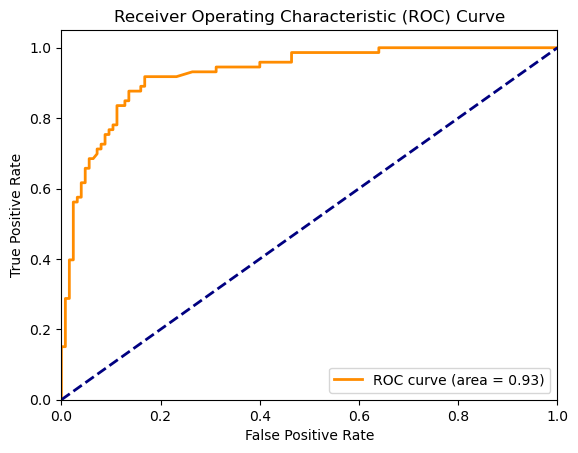

In [21]:
### RUN FOR HYPER TUNING ONLY ###
## MINIMUM ETA = 2 HOURS ##

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Set a random seed for reproducibility
torch.manual_seed(36)
np.random.seed(36)

# Load the dataset
data = pd.read_csv("C:\\Users\\LE\\Downloads\\THESIS\\Program\\CSV\\GRID_LABEL_KTMBASIN_1KM_Classify.csv")

# Calculate correlation of the dataset
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Draw heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Preprocess the data
X = data[["NEAR_DIST", "bedrockdep", "vs30", "predom", "pga", "geomap"]]
y = data["LIQ"]

# Calculate VIF
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print("Variance Inflation Factor (VIF):")
print(vif)

# Create a custom dataset class
class LiquefactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X.iloc[idx, :].values
        y = self.y.iloc[idx]
        return {
            'x': torch.tensor(x, dtype=torch.float),
            'y': torch.tensor(y, dtype=torch.long)
        }

# Create data loaders
max_depth = 10  # maximum depth of the decision tree
n_estimators = 100  # number of decision trees in the ensemble
random_state = 36  # random state for reproducibility
test_size = 0.3  # test size for testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) 
 
dataset_train = LiquefactionDataset(X_train, y_train) 
dataset_test = LiquefactionDataset(X_test, y_test)

batch_size = 1
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)

# Define the DNN model
class DNNModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(6, hidden_size)  # input layer (7) -> hidden layer (hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # hidden layer (hidden_size) -> hidden layer (hidden_size)
        self.fc3 = nn.Linear(hidden_size, 2)  # hidden layer (hidden_size) -> output layer (2)
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.size(0)  # get the batch size
        x = x.view(batch_size, 6)  # reshape the input tensor
        x = torch.relu(self.fc1(x))  # activation function for hidden layer
        for _ in range(self.num_layers - 1):
            x = torch.relu(self.fc2(x))  # activation function for hidden layer
        x = self.fc3(x)
        return x

# Hyperparameter tuning
def objective(trial):
    # Define hyperparameter search space
    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])

    # Create model with hyperparameters
    model = DNNModel(hidden_size, num_layers)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    for epoch in range(100):
        running_loss = 0.0
        for i, batch in enumerate(train_loader):
            inputs, labels = batch['x'], batch['y']
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss / i:.3f}')

    # Evaluate model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['x'], batch['y']
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = correct / len(test_loader.dataset)
    return -accuracy  # Optuna minimizes the objective function

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_params)
print('Best accuracy:', -study.best_value)

# Train the model with the best hyperparameters
best_model = DNNModel(study.best_params['hidden_size'], study.best_params['num_layers'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=study.best_params['learning_rate'])

# Train the model
for epoch in range(100):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        inputs, labels = batch['x'], batch['y']
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / i:.3f}')

# Evaluate the model
best_model.eval()
test_loss = 0
correct = 0
y_pred_probs = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['x'], batch['y']
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_pred_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = correct / len(test_loader.dataset)
print(f'Test Accuracy: {accuracy:.3f}')

# Calculate precision, recall, F1-score
y_pred = np.array(y_pred_probs) >= 0.5
y_true = np.array(y_true)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

# Calculate AUROC
auroc = roc_auc_score(y_true, y_pred_probs)
print(f'AUROC: {auroc:.3f}')

# Calculate Kappa score
kappa = cohen_kappa_score(y_true, y_pred)
print(f'Cohen Kappa Score: {kappa:.3f}')

# Calculate confusion matrix
conf_mat = torch.zeros(2, 2)
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['x'], batch['y']
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels, predicted):
            conf_mat[t, p] += 1

print("Confusion Matrix:")
print(conf_mat)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', -study.best_value)

Best hyperparameters: {'batch_size': 4, 'learning_rate': 0.00022077530065383875, 'hidden_size': 64, 'num_layers': 2}
Best accuracy: 0.8888888888888888
